In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

## Introduction

在上一章中，我们处理了“教科书”问题。 这些问题很容易陈述、编写几行代码并进行教学。 现实世界的问题很少这么简单。 在本章中，我们将使用更实际的示例，并学习如何评估过滤器性能。

我们将从在 2D 空间（例如田地或仓库）中跟踪机器人开始。 我们将从一个简单的噪声传感器开始，它输出噪声 $(x,y)$ 坐标，我们需要对其进行过滤以生成 2D 轨迹。 一旦我们掌握了这个概念，我们将通过更多传感器显着扩展问题，然后添加控制输入。

然后我们将转向非线性问题。 世界是非线性的，但卡尔曼滤波器是线性的。 有时你可以用它来解决轻微的非线性问题，有时你不能。 我将向您展示两者的示例。 这将为本书的其余部分奠定基础，我们将在其中学习非线性问题的技术。

## Tracking a Robot

跟踪机器人的第一次尝试将与前几章的一维狗跟踪问题非常相似。 我们现在有一个传感器来提供二维空间中的位置噪声测量，而不是输出走廊中的位置的传感器。 在每次 $t$ 时，它将提供传感器在现场位置的噪声测量值的 $(x,y)$ 坐标对。

与真实传感器交互的代码实现超出了本书的范围，因此我们将像之前一样编写传感器的简单模拟程序。 我们将开发几个这样的传感器，每个都有更多的复杂性，所以当我对它们进行编程时，我只会在函数名称后面附加一个数字。

因此，让我们从一个非常简单的传感器开始，它可以模拟跟踪直线运动的物体。 它使用初始位置、速度和噪声标准偏差进行初始化。 每次调用 `read()` 都会将位置更新一个时间步并返回新的测量值。

In [3]:
from numpy.random import randn

class PosSensor(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

快速测试以验证它是否按我们的预期工作。

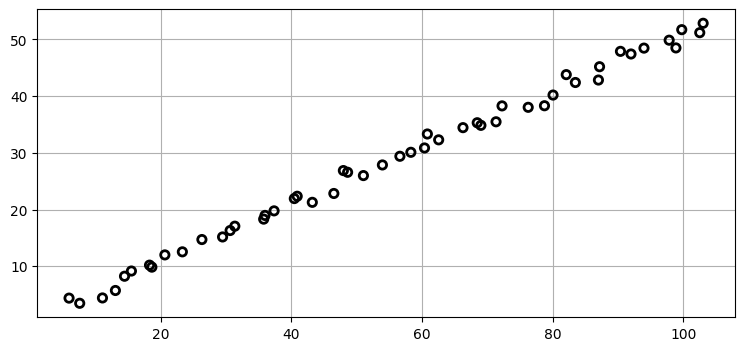

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from kf_book.book_plots import plot_measurements

pos, vel = (4, 3), (2, 1)
sensor = PosSensor(pos, vel, noise_std=1)
ps = np.array([sensor.read() for _ in range(50)])
plot_measurements(ps[:, 0], ps[:, 1]);

这看起来是正确的。 斜率为 1/2，正如我们预期的速度为 (2, 1)，数据似乎从 (6, 4) 附近开始。 看起来不太现实。 这仍然是一个“教科书”表示。 随着我们的继续，我们将添加增加现实世界行为的复杂性。

### Choose the State Variables

与往常一样，第一步是选择我们的状态变量。 我们在二维中进行跟踪，并且有一个传感器可以为我们提供这两个维度中的每一个的读数，因此我们知道我们有两个*观察到的变量*$x$ 和 $y$。 如果我们只使用这两个变量创建我们的卡尔曼滤波器，性能将不会很好，因为我们会忽略速度可以提供给我们的信息。 我们也希望将速度纳入我们的方程。 我将把它表示为

$$\mathbf x = 
\begin{bmatrix}x & \dot x & y & \dot y\end{bmatrix}^\mathsf T$$

这个组织没有什么特别之处。 我本可以使用 $\begin{bmatrix}x & y & \dot x & \dot y\end{bmatrix}^\mathsf T$ 或不合逻辑的东西。 我只需要在其余矩阵中保持一致。 我喜欢保持位置和速度彼此相邻，因为它将位置和速度之间的协方差保持在协方差矩阵的同一子块中。 在我的公式中，`P[1,0]` 包含 $x$ 和 $\dot x$ 的协方差。 在替代公式中，协方差位于“P[2, 0]”。 随着维度数量的增加，这种情况会变得更糟。

让我们暂停一下并讨论如何识别隐藏变量。这个例子有点明显，因为我们已经处理过 1D 案例，但其他问题并不明显。这个问题没有简单的答案。首先要问自己的是传感器数据的一阶和二阶导数的解释是什么。我们这样做是因为如果您使用固定时间步长从传感器读取数据，那么获得一阶和二阶导数在数学上是微不足道的。一阶导数只是两个连续读数之间的差。在我们的跟踪案例中，一阶导数有一个明显的物理解释：两个连续位置之间的差异是速度。

除此之外，您还可以开始研究如何组合来自两个或更多不同传感器的数据以产生更多信息。这开辟了*传感器融合*领域，我们将在后面的部分中介绍这方面的示例。现在，要认识到选择适当的状态变量对于从过滤器中获得最佳性能至关重要。选择隐藏变量后，您必须运行许多测试以确保为它们生成真实结果。卡尔曼滤波器运行你给它的任何模型；如果您的模型无法为隐藏变量生成好的信息，则卡尔曼滤波器输出将是无意义的。

### Design State Transition Function

我们的下一步是设计状态转换函数。 回想一下，状态转换函数是作为矩阵 $\mathbf F$ 实现的，我们将它与系统的前一个状态相乘以获得下一个状态，就像这样。

$$\mathbf{\bar x} = \mathbf{Fx}$$

我不会对此进行详细说明，因为它与我们在前一章中所做的一维案例非常相似。 状态转移方程是

$$
\begin{aligned}
x &= 1x + \Delta t \dot x + 0y + 0 \dot y \\
v_x &= 0x + 1\dot x + 0y + 0 \dot y \\
y &= 0x + 0\dot x + 1y + \Delta t \dot y \\
v_y &= 0x + 0\dot x + 0y + 1 \dot y
\end{aligned}
$$

以这种方式布局向我们展示了 $\small\mathbf F$ 所需的值和行列组织。 我们将其转换为矩阵向量形式：

$$
\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix} = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix}\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix}$$

所以，让我们用 Python 来做这件事。 这很简单； 这里唯一的新功能是将 `dim_z` 设置为 2。我们将在第 4 步中了解为什么将其设置为 2。

In [5]:
from filterpy.kalman import KalmanFilter

tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.   # time step 1 second

tracker.F = np.array([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])

### Design the Process Noise Matrix

FilterPy 可以为我们计算 $\mathbf Q$ 矩阵。 为简单起见，我将假设噪声是离散时间维纳过程 - 每个时间段都是恒定的。 这个假设允许我使用方差来指定我认为模型在步骤之间的变化程度。 如果不清楚，请重新访问卡尔曼滤波器数学章节。

In [6]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.    0.001 0.    0.   ]
 [0.001 0.001 0.    0.   ]
 [0.    0.    0.    0.001]
 [0.    0.    0.001 0.001]]


这里我假设 x 和 y 中的噪声是独立的，因此任何 x 和 y 变量之间的协方差应该为零。 这允许我计算一维的 $\mathbf Q$，然后使用 `block_diag` 将其复制到 x 和 y 轴。



### Design the Control Function

我们还没有为我们的机器人添加控件，所以这一步不需要做任何事情。 `KalmanFilter` 类在没有控制输入的假设下将`B` 初始化为零，
所以没有代码可写。 如果你愿意，你可以显式地将 `tracker.B` 设置为 0，但正如你所见，它已经具有该值。

In [7]:
tracker.B

### Design the Measurement Function

测量函数 $\mathbf H$ 使用方程 $\mathbf z = \mathbf{Hx}$ 定义了我们如何从状态变量到测量值。 在这种情况下，我们有 (x,y) 的测量值，因此我们将 $\mathbf z$ 设计为 $\begin{bmatrix}x & y\end{bmatrix}^\mathsf T$，其维度为 2x1。 我们的状态变量大小为 4x1。 我们可以通过回忆将大小为 MxN 的矩阵乘以 NxP 得到大小为 MxP 的矩阵来推断 $\textbf{H}$ 所需的大小。 因此，

$$(2\times 1) = (a\times b)(4 \times 1) = (2\times 4)(4\times 1)$$

So, $\textbf{H}$ is 2x4.

填写 $\textbf{H}$ 的值很容易，因为测量的是机器人的位置，即状态 $\textbf{x}$ 的 $x$ 和 $y$ 变量。 让我们通过决定我们要更改单位来使这变得更有趣。 测量结果以英尺为单位，我们希望以米为单位。 $\textbf{H}$ 从状态变为测量值，因此转换为 $\mathsf{feet} = \mathsf{meters} / 0.3048$。 这产生

$$\mathbf H =
\begin{bmatrix} 
\frac{1}{0.3048} & 0 & 0 & 0 \\
0 & 0 & \frac{1}{0.3048} & 0
\end{bmatrix}
$$

对应于这些线性方程

$$
\begin{aligned}
z_x &= (\frac{x}{0.3048}) + (0* v_x) + (0*y) + (0 * v_y) = \frac{x}{0.3048}\\
z_y &= (0*x) + (0* v_x) + (\frac{y}{0.3048}) + (0 * v_y) = \frac{y}{0.3048}
\end{aligned}
$$

这是一个简单的问题，我们可以直接找到方程式，而无需经过我上面所做的维度分析。 但是记住卡尔曼滤波器的方程对所有矩阵都意味着一个特定的维度是很有用的，当我开始迷失如何设计一些东西时，查看矩阵维度是很有用的。

这是我的实现：

In [8]:
tracker.H = np.array([[1/0.3048, 0, 0,        0],
                      [0,        0, 1/0.3048, 0]])

### Design the Measurement Noise Matrix

我们假设 $x$ 和 $y$ 变量是独立的白高斯过程。 也就是说，x 中的噪声与 y 中的噪声没有任何关系，并且噪声正态分布在均值 0 附近。现在让我们将 $x$ 和 $y$ 的方差设置为 5 米$^ 2 美元。 它们是独立的，因此没有协方差，并且我们的非对角线将为 0。这给了我们：

$$\mathbf R = \begin{bmatrix}\sigma_x^2 & \sigma_y\sigma_x \\ \sigma_x\sigma_y & \sigma_{y}^2\end{bmatrix} 
= \begin{bmatrix}5&0\\0&5\end{bmatrix}$$

这是一个 $2{\times}2$ 矩阵，因为我们有 2 个传感器输入，对于 $n$ 个变量，协方差矩阵的大小总是 $n{\times}n$。 在 Python 中，我们编写：

In [9]:
tracker.R = np.array([[5., 0],
                      [0, 5]])
tracker.R

array([[5., 0.],
       [0., 5.]])

### Initial Conditions

对于我们的简单问题，我们将初始位置设置为 (0,0)，速度为 (0,0)。 由于这是一个纯粹的猜测，我们将协方差矩阵 $\small\mathbf P$ 设置为一个较大的值。

$$ \mathbf x = \begin{bmatrix}0\\0\\0\\0\end{bmatrix}, \,
\mathbf P = \begin{bmatrix}500&0&0&0\\0&500&0&0\\0&0&500&0\\0&0&0&500\end{bmatrix}$$

Python实现是


In [10]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

### Implement the Filter

设计完成，现在我们只需要编写代码来运行过滤器并以我们选择的格式输出数据。 我们将运行代码 30 次迭代。

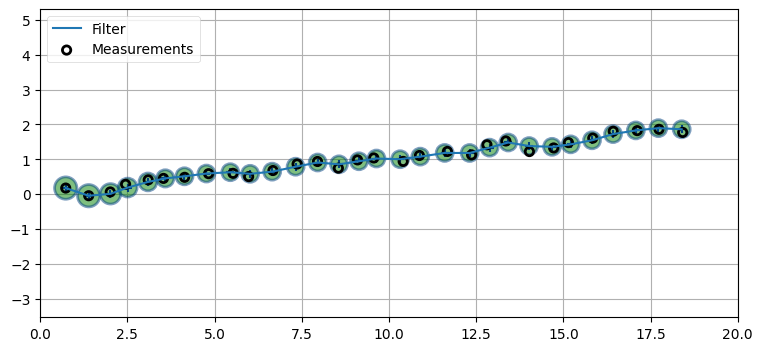

In [11]:
from filterpy.stats import plot_covariance_ellipse
from kf_book.book_plots import plot_filter

R_std = 0.35
Q_std = 0.04

def tracker1():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.0   # time step

    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1/0.3048, 0, 0, 0],
                          [0, 0, 1/0.3048, 0]])

    tracker.R = np.eye(2) * R_std**2
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 500.
    return tracker

# simulate robot movement
N = 30
sensor = PosSensor((0, 0), (2, .2), noise_std=R_std)

zs = np.array([sensor.read() for _ in range(N)])

# run filter
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)
    
#plot results
zs *= .3048 # convert to meters
plot_filter(mu[:, 0], mu[:, 2])
plot_measurements(zs[:, 0], zs[:, 1])
plt.legend(loc=2)
plt.xlim(0, 20);

我鼓励你玩这个，将 $\mathbf Q$ 和 $\mathbf R$ 设置为不同的值。 但是，我们在最后几章中做了很多类似的事情，而且我们有很多材料要涵盖，所以我将继续讨论更复杂的案例，我们也将有机会体验更改这些值。

我为 $x$ 和 $y$ 绘制了绿色的 $3\sigma$ 协方差椭圆。 你能解释一下它们的形状吗？ 也许你期待的是一个倾斜的椭圆，就像在最后几章中一样。 如果是这样，请回想一下，在那些章节中，我们不是绘制 $x$ 与 $y$，而是绘制 $x$ 与 $\dot x$。 $x$ 与 $\dot x$ 相关，但 $x$ 不相关或不依赖于 $y$。 因此我们的椭圆没有倾斜。 此外，$x$ 和 $y$ 的噪声被建模为具有相同的噪声标准偏差。 例如，如果我们将 R 设置为

$$\mathbf R = \begin{bmatrix}1&0\\0&.5\end{bmatrix}$$

我们会告诉卡尔曼滤波器，$x$ 中的噪声比 $y$ 多，我们的椭圆会比它们的高更长。

$\mathbf P$ 的最终值告诉我们关于状态变量之间相关性的所有信息。 如果我们只看对角线，我们会看到每个变量的方差。 换句话说，$\mathbf P_{0,0}$ 是 x 的方差，$\mathbf P_{1,1}$ 是 $\dot x$ 的方差，$\mathbf P_{2,2}$ 是 y 的方差，$\mathbf P_{3,3}$ 是 $\dot y$ 的方差。 我们可以使用 numpy.diag() 提取矩阵的对角线。

In [12]:
print(np.diag(robot_tracker.P))

[0.007 0.003 0.007 0.003]


协方差矩阵包含四个 $2{\times}2$ 矩阵，您应该能够轻松挑选出它们。 这是由于 $x$ 与 $\dot x$ 以及 $y$ 与 $\dot y$ 的相关性。 左上角显示了 $x$ 到 $\dot x$ 的协方差。

[[0.007 0.003]
 [0.003 0.003]]


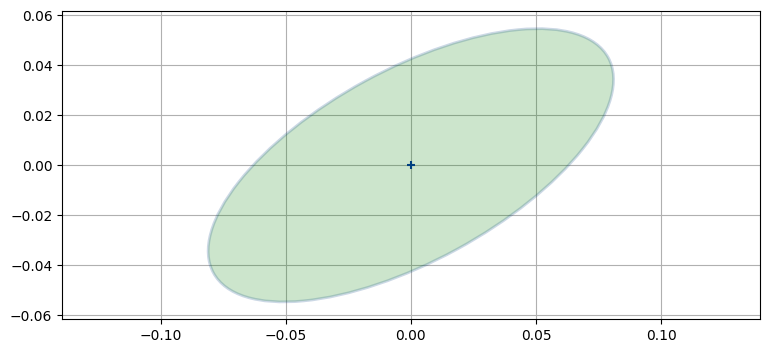

In [13]:
c = robot_tracker.P[0:2, 0:2]
print(c)
plot_covariance_ellipse((0, 0), cov=c, fc='g', alpha=0.2)

协方差包含左上角 $x$ 和 $\dot x$ 的数据，因为它是如何组织的。 回想一下条目 $\mathbf P_{i,j}$ 和 $\mathbf P_{j,i}$ 包含 $\sigma_i\sigma_j$。

最后我们看一下$\mathbf P$的左下角，全是0。 为什么是 0？ 考虑 $\mathbf P_{3,0}$。 它存储了 $\sigma_3\sigma_0$ 项，它是 $\dot y$ 和 $x$ 之间的协方差。 这些是独立的，因此项将为 0。其余项用于类似的自变量。

In [14]:
robot_tracker.P[2:4, 0:2]

array([[0., 0.],
       [0., 0.]])

## Filter Order

我们只研究了跟踪位置和速度。 它运作良好，但这只是因为我一直在选择适合选择的问题。 您现在有足够的卡尔曼滤波器经验，可以更一般地考虑这一点。

我说的顺序是什么意思？ 在这些系统模型的上下文中，它是准确建模系统所需的导数。 考虑一个不变的系统，例如建筑物的高度。 没有变化，所以不需要导数，系统的阶为零。 我们可以将其表示为 $x = 312.5$。

一阶系统具有一阶导数。 例如，位置的变化就是速度，我们可以写成

$$ v = \frac{dx}{dt}$$

我们将其整合到牛顿方程中

$$ x = vt + x_0.$$

由于假设速度恒定，这也称为*恒定速度*模型。

二阶系统具有二阶导数。 位置的二阶导数是加速度，方程为

$$a = \frac{d^2x}{dt^2}$$

我们融入其中

$$ x = \frac{1}{2}at^2 +v_0t + x_0.$$

这也称为*恒定加速度*模型。

另一种等效的方法是考虑多项式的阶数。 恒加速度模型具有二阶导数，因此是二阶的。 同样，多项式 $x = \frac{1}{2}at^2 +v_0t + x_0$ 是二阶的。

当我们设计状态变量和过程模型时，我们必须选择我们想要建模的系统的顺序。 假设我们正在以恒定的速度跟踪某物。 现实世界中没有一个过程是完美的，因此在短时间内速度会有轻微的变化。 您可能会认为最好的方法是使用二阶滤波器，允许加速度项处理速度的微小变化。

在实践中效果并不好。 为了彻底理解这个问题，让我们看看使用与被过滤系统的顺序不匹配的流程模型的效果。

首先，我们需要一个过滤系统。 我将编写一个类来模拟具有恒定速度的对象。 基本上没有物理系统具有真正恒定的速度，因此在每次更新时，我们都会稍微改变速度。 我还编写了一个传感器来模拟传感器中的高斯噪声。 代码如下，我绘制了一个示例运行以验证它是否正常工作。

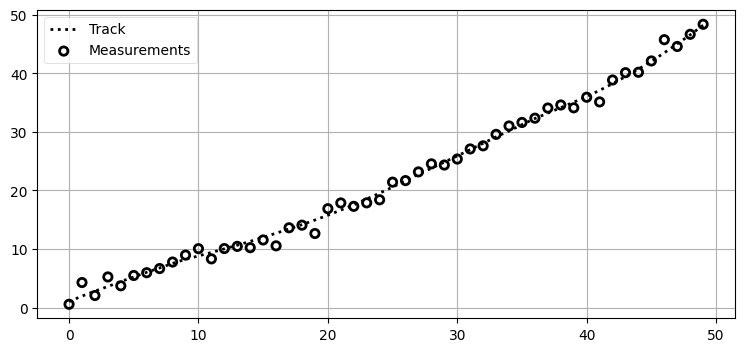

In [15]:
from kf_book.book_plots import plot_track

class ConstantVelocityObject(object):
    def __init__(self, x0=0, vel=1., noise_scale=0.06):
        self.x = x0
        self.vel = vel
        self.noise_scale = noise_scale

    def update(self):
        self.vel += randn() * self.noise_scale
        self.x += self.vel
        return (self.x, self.vel)

def sense(x, noise_scale=1.):
    return x[0] + randn()*noise_scale

np.random.seed(124)
obj = ConstantVelocityObject()

xs, zs = [], []
for i in range(50):
    x = obj.update()
    z = sense(x)
    xs.append(x)
    zs.append(z)

xs = np.asarray(xs)

plot_track(xs[:, 0])
plot_measurements(range(len(zs)), zs)
plt.legend(loc='best');

我对这个情节很满意。 由于我们添加到系统中的噪音，轨道并不完全笔直 - 这可能是一个人在街上行走的轨道，或者可能是一架飞机受到多变风的冲击。 这里没有有意的加速度，所以我们称之为恒速系统。 再一次，你可能会问自己，既然实际上有一点点加速，为什么我们不使用二阶卡尔曼滤波器来解释这些变化？ 让我们来了解一下。

如何设计零阶、一阶或二阶卡尔曼滤波器？ 我们一直在这样做，但只是不使用这些术语。 这可能有点乏味，但我会详细说明每一个 - 如果你清楚这个概念，请随意略读。

### Zero Order Kalman Filter

零阶卡尔曼滤波器只是一个没有导数的跟踪滤波器。 我们正在跟踪位置，这意味着我们只有一个位置状态变量（没有速度或加速度），并且状态转换函数也只考虑位置。 使用矩阵公式，我们可以说状态变量是

$$\mathbf x = \begin{bmatrix}x\end{bmatrix}$$

状态转换函数非常简单。 位置没有变化，所以我们需要建模$x=x$; 换句话说，时间 t+1 的 *x* 与时间 t 相同。 在矩阵形式中，我们的状态转移函数是

$$\mathbf F = \begin{bmatrix}1\end{bmatrix}$$

测量功能非常简单。 回想一下，我们需要定义如何将状态变量 $\mathbf x$ 转换为测量值。 我们将假设我们的测量是位置。 状态变量只包含一个位置，所以我们得到

$$\mathbf H = \begin{bmatrix}1\end{bmatrix}$$

让我们编写一个构造并返回零阶卡尔曼滤波器的函数。

In [16]:
def ZeroOrderKF(R, Q, P=20):
    """ Create zero order Kalman filter.
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([0.])
    kf.R *= R
    kf.Q *= Q
    kf.P *= P
    kf.F = np.eye(1)
    kf.H = np.eye(1)
    return kf

### First Order Kalman Filter

一阶卡尔曼滤波器跟踪一阶系统，例如位置和速度。 我们已经为上面的狗跟踪问题做了这个，所以这应该很清楚。 但让我们再做一次。

一阶系统具有位置和速度，因此状态变量需要这两者。 矩阵公式可以是

$$ \mathbf x = \begin{bmatrix}x\\\dot x\end{bmatrix}$$

所以现在我们必须设计我们的状态转换。 时间步长的牛顿方程为：

$$\begin{aligned} x_t &= x_{t-1} + v\Delta t \\
 v_t &= v_{t-1}\end{aligned}$$
 
回想一下，我们需要将其转换为线性方程

$$\begin{bmatrix}x\\\dot x\end{bmatrix} = \mathbf F\begin{bmatrix}x\\\dot x\end{bmatrix}$$

Setting

$$\mathbf F = \begin{bmatrix}1 &\Delta t\\ 0 & 1\end{bmatrix}$$

给我们上面的方程。

最后，我们设计了测量函数。 测量功能需要实现

$$\mathbf z = \mathbf{Hx}$$

我们的传感器仍然只读取位置，因此它应该从状态中获取位置，并将速度和加速度设为 0，如下所示：

$$\mathbf H = \begin{bmatrix}1 & 0 \end{bmatrix}$$

该函数构造并返回一阶卡尔曼滤波器。

In [17]:
def FirstOrderKF(R, Q, dt):
    """ Create first order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf

### Second Order Kalman Filter

二阶卡尔曼滤波器跟踪二阶系统，例如位置、速度和加速度。 状态变量将是

$$ \mathbf x = \begin{bmatrix}x\\\dot x\\\ddot{x}\end{bmatrix}$$

所以现在我们必须设计我们的状态转换。 时间步长的牛顿方程为：

$$\begin{aligned} x_t &= x_{t-1} + v_{t-1}\Delta t + 0.5a_{t-1} \Delta t^2 \\
 v_t &= v_{t-1} + a_{t-1}\Delta t \\
 a_t &= a_{t-1}\end{aligned}$$
 
回想一下，我们需要将其转换为线性方程

$$\begin{bmatrix}x\\\dot x\\\ddot{x}\end{bmatrix} = \mathbf F\begin{bmatrix}x\\\dot x\\\ddot{x}\end{bmatrix}$$

Setting

$$\mathbf F = \begin{bmatrix}1 & \Delta t &.5\Delta t^2\\ 
0 & 1 & \Delta t \\
0 & 0 & 1\end{bmatrix}$$

给我们上面的方程。

最后，我们设计了测量函数。 测量功能需要实现

$$z = \mathbf{Hx}$$

我们的传感器仍然只读取位置，因此它应该从状态中获取位置，并将速度设为 0，如下所示：

$$\mathbf H = \begin{bmatrix}1 & 0 & 0\end{bmatrix}$$

该函数构造并返回二阶卡尔曼滤波器。

In [18]:
def SecondOrderKF(R_std, Q, dt, P=100):
    """ Create second order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=3, dim_z=1)
    kf.x = np.zeros(3)
    kf.P[0, 0] = P
    kf.P[1, 1] = 1
    kf.P[2, 2] = 1
    kf.R *= R_std**2
    kf.Q = Q_discrete_white_noise(3, dt, Q)
    kf.F = np.array([[1., dt, .5*dt*dt],
                     [0., 1.,       dt],
                     [0., 0.,       1.]])
    kf.H = np.array([[1., 0., 0.]])
    return kf

## Evaluating Filter Order


现在我们可以针对模拟运行每个卡尔曼滤波器并评估结果。

我们如何评估结果？我们可以通过绘制轨迹和卡尔曼滤波器输出并观察结果来定性地做到这一点。但是，严格的方法使用数学。回想一下，系统协方差矩阵 $\mathbf P$ 包含每个状态变量的计算方差和协方差。对角线包含方差。请记住，如果噪声是高斯噪声，大约 99% 的测量值落在 $3\sigma$ 以内。如果不清楚，请在继续之前查看高斯章节，因为这是重要的一点。

因此，我们可以通过查看估计状态和实际状态之间的残差并将它们与我们从 $\mathbf P$ 得出的标准差进行比较来评估过滤器。如果过滤器正确执行，99% 的残差将落在 $3\sigma$ 内。这适用于所有状态变量，而不仅仅是位置。

我必须提到，这仅适用于模拟系统。真实传感器不是完全高斯的，您可能需要将您的标准扩展为，例如，使用真实传感器数据的 $5\sigma$。

因此，让我们针对我们的一阶系统运行一阶卡尔曼滤波器并访问其性能。您可能会猜到它会做得很好，但让我们使用标准偏差来看看它。

首先，让我们编写一个例程来为我们生成噪声测量值。

In [19]:
def simulate_system(Q, count):
    obj = ConstantVelocityObject(x0=.0, vel=0.5, noise_scale=Q)
    xs, zs = [], []
    for i in range(count):
        x = obj.update()
        z = sense(x)
        xs.append(x)
        zs.append(z)
    return np.array(xs), np.array(zs)

现在是一个执行过滤并将输出保存在“Saver”对象中的例程。

In [20]:
from filterpy.common import Saver

def filter_data(kf, zs):
    s = Saver(kf)
    kf.batch_filter(zs, saver=s)
    s.to_array()
    return s

现在我们准备运行过滤器并查看结果。

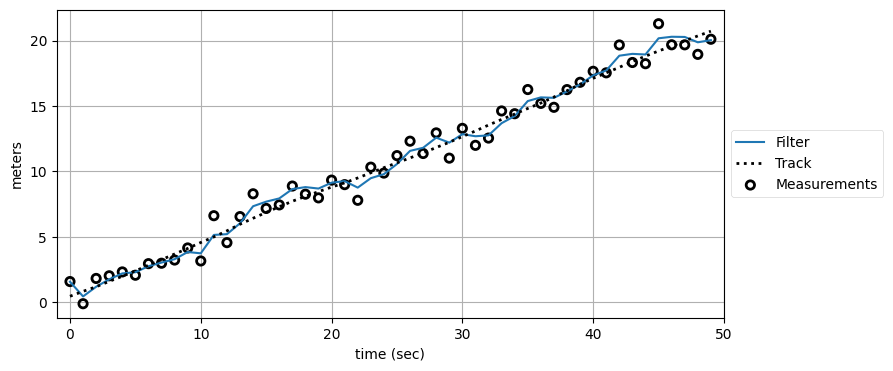

In [21]:
from kf_book.book_plots import plot_kf_output

R, Q = 1, 0.03
xs, zs = simulate_system(Q=Q, count=50)

kf = FirstOrderKF(R, Q, dt=1)
data1 = filter_data(kf, zs)

plot_kf_output(xs, data1.x, data1.z)

看起来过滤器的性能很好，但很难说到底有多好。 让我们看看残差，看看它们是否有帮助。 我们会经常这样做，所以我将编写一个函数来绘制它们。

In [22]:
from kf_book.book_plots import plot_residual_limits, set_labels

def plot_residuals(xs, data, col, title, y_label, stds=1):
    res = xs - data.x[:, col]
    plt.plot(res)
    plot_residual_limits(data.P[:, col, col], stds)
    set_labels(title, 'time (sec)', y_label)

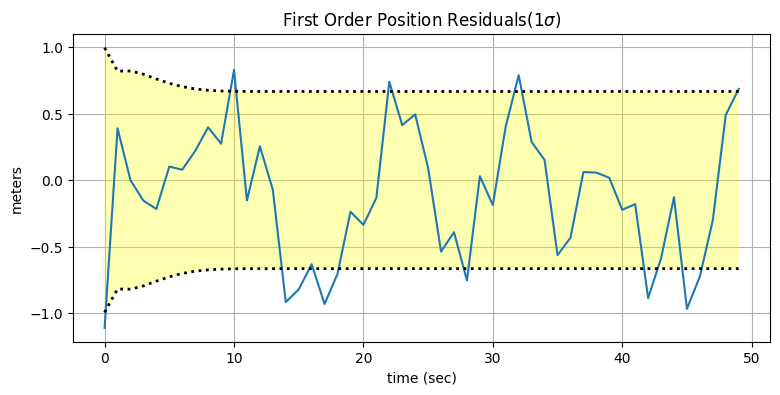

In [23]:
plot_residuals(xs[:, 0], data1, 0, 
               title='First Order Position Residuals(1$\sigma$)',
               y_label='meters')   

我们如何解释这个情节？ 残差绘制为锯齿线 - 测量值与预测位置之间的差异。 如果没有测量噪声并且卡尔曼滤波器预测总是完美的，那么残差总是为零。 所以理想的输出是 0 处的水平线。我们可以看到残差以 0 为中心，所以这让我们确信噪声是高斯的（因为误差在 0 上下均等）。 虚线之间的黄色区域显示了滤波器在 1 个标准偏差下的理论性能。 换句话说，大约 68% 的错误应该在虚线范围内。 残差在这个范围内，所以我们看到过滤器表现良好，并且没有发散。

让我们看看速度的残差。

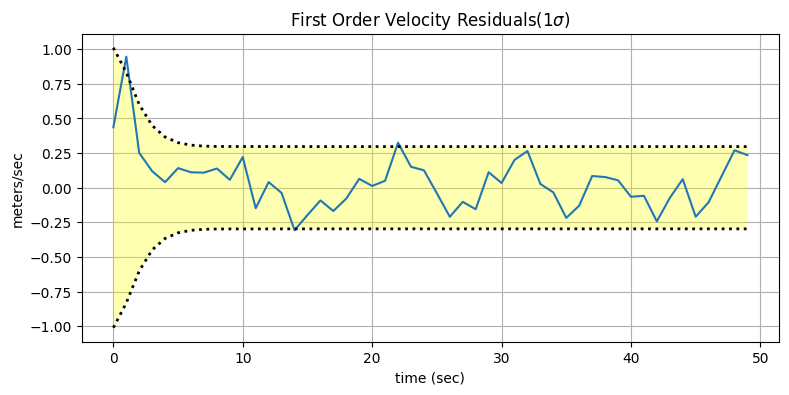

In [24]:
plot_residuals(xs[:, 1], data1, 1, 
               title='First Order Velocity Residuals(1$\sigma$)',
               y_label='meters/sec')   

同样，正如预期的那样，残差落在过滤器的理论性能范围内，因此我们确信过滤器是为该系统精心设计的。

现在让我们使用零阶卡尔曼滤波器做同样的事情。 所有的代码和数学基本相同，所以让我们只看结果而不讨论实现。

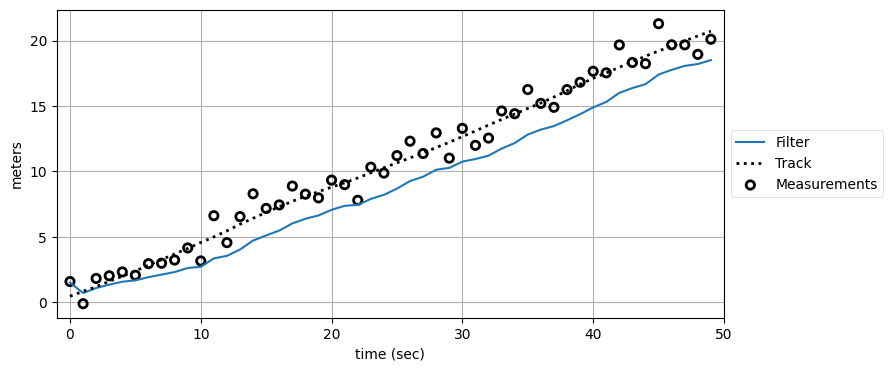

In [25]:
kf0 = ZeroOrderKF(R, Q)
data0 = filter_data(kf0, zs)
plot_kf_output(xs, data0.x, data0.z)

正如我们所料，过滤器有问题。回想一下 g-h 滤波器，我们将加速度纳入系统。 g-h 滤波器总是滞后于输入，因为没有足够的项来让滤波器足够快地适应速度的变化。在每个“predict()”步骤中，卡尔曼滤波器假设位置没有变化——如果当前位置是 4.3，它将预测下一个时间段的位置是 4.3。当然，实际位置更接近5.3。带有噪声的测量值可能是 5.4，因此过滤器选择了介于 4.3 和 5.4 之间的估计值，导致它大大滞后于 5.3 的实际值。同样的事情发生在下一步，下一个，依此类推。过滤器永远赶不上。

这提出了一个非常重要的观点。 “恒定”假设仅是离散样本之间的恒定性假设。滤波器的输出仍会随时间而变化。

现在让我们看看残差。我们没有跟踪速度，所以我们只能查看残差的位置。

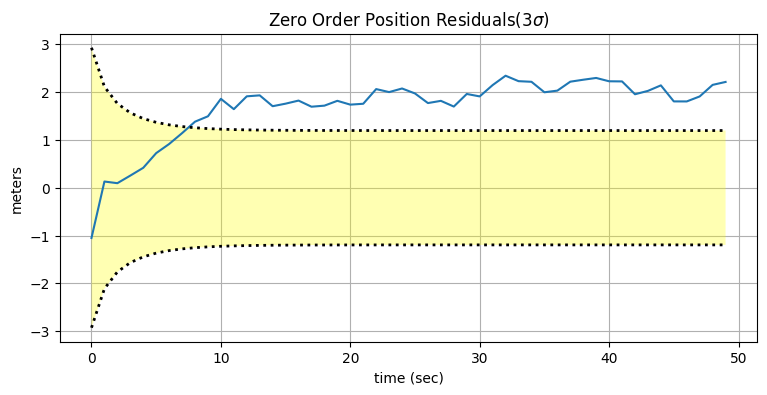

In [26]:
plot_residuals(xs[:, 0], data0, 0, 
               title='Zero Order Position Residuals(3$\sigma$)',
               y_label='meters',
               stds=3)

我们可以看到过滤器几乎立即发散。几秒钟后，残差超过了三个标准偏差的界限。重要的是要理解协方差矩阵 $\mathbf P$ 仅报告*假设*所有输入正确的滤波器的*理论*性能。换句话说，这个卡尔曼滤波器是发散的，但是 $\mathbf P$ 意味着卡尔曼滤波器的估计随着时间的推移越来越好，因为方差越来越小。过滤器无法知道您在对系统撒谎。这有时被称为 *smug* 过滤器 - 它对其性能过于自信。

在这个系统中，分歧是直接而引人注目的。在许多系统中，它只会是渐进的和/或轻微的。为您的系统查看此类图表非常重要，以确保过滤器的性能在其理论性能范围内。

现在让我们尝试一个二阶系统。这可能会让你觉得这是一件好事。毕竟，我们知道模拟物体的运动中有一点噪音，这意味着有一些加速度。为什么不用二阶模型来模拟加速度呢？如果没有加速度，加速度应该只是估计为0，对吧？但会发生这种情况吗？在继续之前考虑一下。

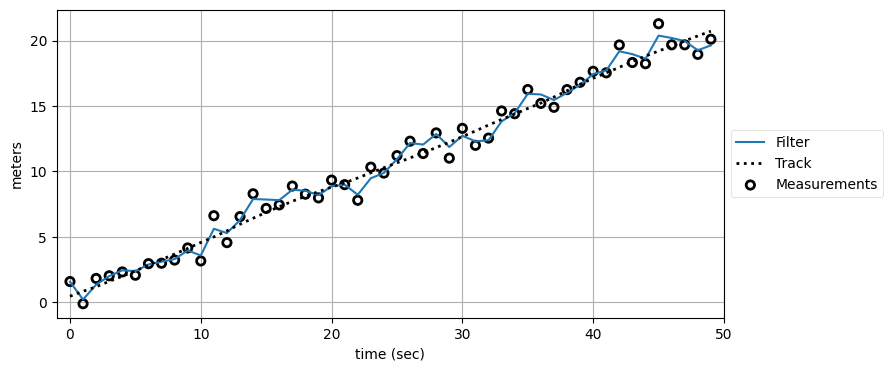

In [27]:
kf2 = SecondOrderKF(R, Q, dt=1)
data2 = filter_data(kf2, zs)
plot_kf_output(xs, data2.x, data2.z)

这是否符合您的预期？

我们可以看到二阶滤波器与一阶滤波器相比表现不佳。 为什么？ 该滤波器模拟加速度，因此测量中的大变化被解释为加速度而不是噪声。 因此，滤波器密切跟踪噪声。 不仅如此，如果噪声始终高于或低于轨道，它会在某些地方*过冲*噪声，因为过滤器错误地假定了不存在的加速度，因此它的预测在每次测量时都离轨道越来越远 . 这不是一个好的事态。

尽管如此，这首歌看起来并不*可怕*。 让我们看看残差讲述的故事。 我将在这里添加一个皱纹。 二阶系统的残差看起来并不可怕，因为它们不会发散或超过三个标准差。 但是，查看一阶滤波器与二阶滤波器的残差非常有说服力，因此我将两者绘制在同一张图上。

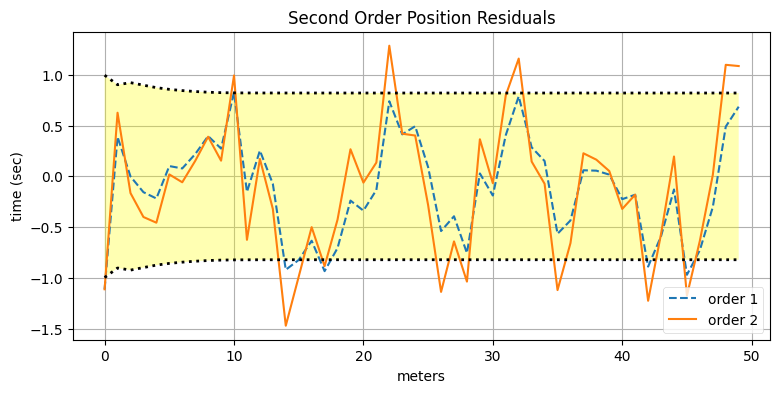

In [28]:
res2 = xs[:, 0] - data2.x[:, 0]
res1 = xs[:, 0] - data1.x[:, 0]

plt.plot(res1, ls="--", label='order 1')
plt.plot(res2, label='order 2')
plot_residual_limits(data2.P[:, 0, 0])
set_labels('Second Order Position Residuals',
           'meters', 'time (sec)')
plt.legend();

二阶位置残差比一阶滤波器的残差略差，但仍落在滤波器的理论极限之内。 这里没有什么非常令人担忧的。

现在让我们看看速度的残差。

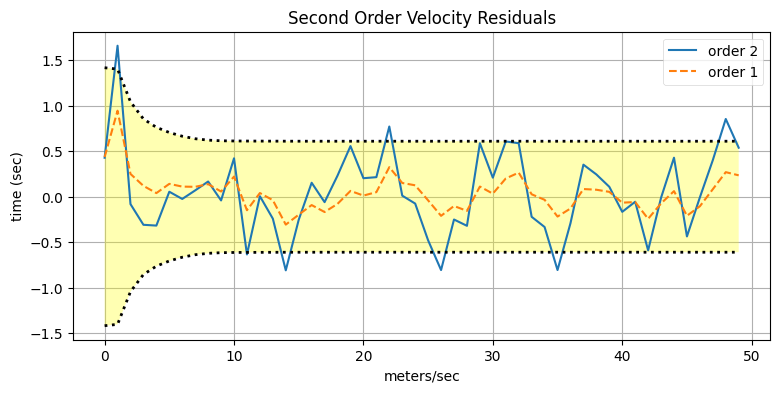

In [29]:
res2 = xs[:, 1] - data2.x[:, 1]
res1 = xs[:, 1] - data1.x[:, 1]

plt.plot(res2, label='order 2')
plt.plot(res1, ls='--', label='order 1')
plot_residual_limits(data2.P[:, 1, 1])
set_labels('Second Order Velocity Residuals', 
                      'meters/sec', 'time (sec)')
plt.legend();

这里的故事非常不同。 虽然二阶系统的残差落在滤波器性能的理论范围内，但我们可以看到残差*远*比一阶滤波器差。 这是这种情况的通常结果。 过滤器假设存在不存在的加速度。 它将测量中的噪声误认为是加速度，并在每个预测周期中将其添加到速度估计中。 当然，加速度实际上并不存在，因此速度的残差远大于其最佳值。

我还有一个绝招。 我们有一个一阶系统； 即速度或多或少是恒定的。 现实世界的系统从来都不是完美的，所以当然速度在时间段之间永远不会完全相同。 当我们使用一阶滤波器时，我们会考虑到速度的轻微变化与*过程噪声*。 计算矩阵 $\mathbf Q$ 以解释这种轻微的变化。 如果我们转向二阶滤波器，我们现在正在考虑速度的变化。 也许现在我们没有过程噪音，我们可以将 $\mathbf Q$ 设置为零！

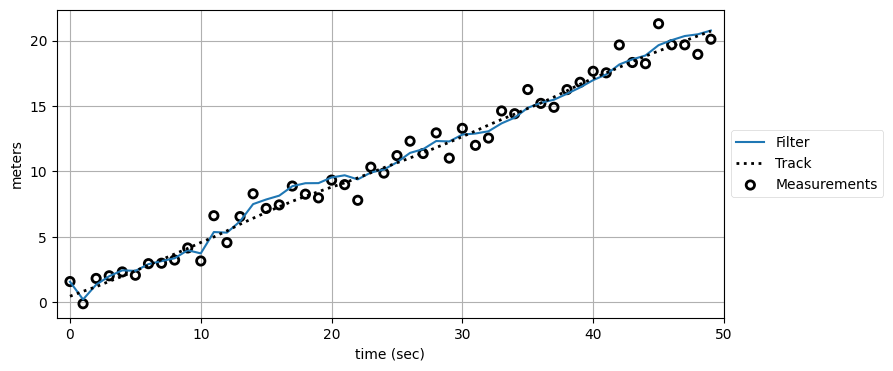

In [30]:
kf2 = SecondOrderKF(R, 0, dt=1)
data2 = filter_data(kf2, zs)
plot_kf_output(xs, data2.x, data2.z)

在我看来，过滤器似乎快速收敛到实际轨道。 成功！

或者可能不是。 将过程噪声设置为 0 告诉过滤器过程模型是完美的。 让我们看看过滤器在较长时间内的性能。

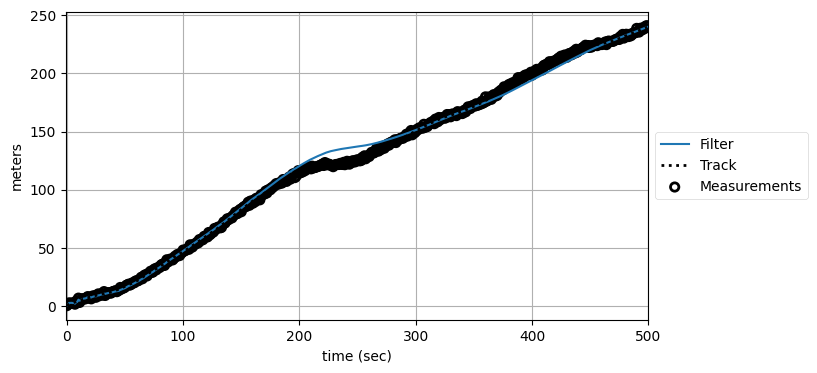

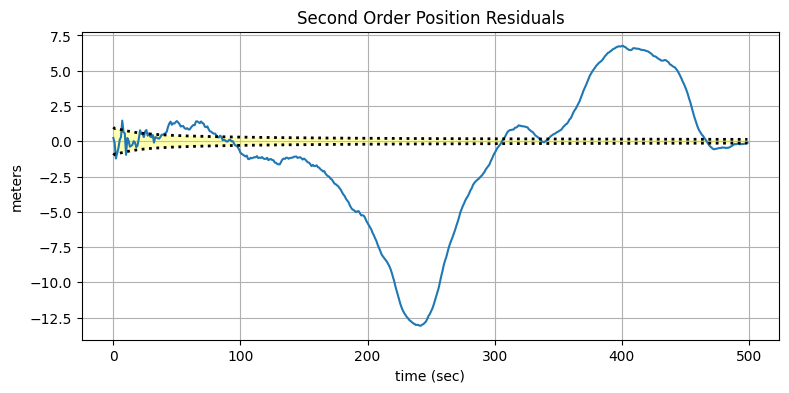

In [31]:
np.random.seed(25944)
xs500, zs500 = simulate_system(Q=Q, count=500)

kf2 = SecondOrderKF(R, 0, dt=1)
data500 = filter_data(kf2, zs500)

plot_kf_output(xs500, data500.x, data500.z)
plot_residuals(xs500[:, 0], data500, 0, 
               'Second Order Position Residuals',
               'meters') 

我们可以看到过滤器的性能非常糟糕。 我们可以在轨迹图中看到，滤波器长时间偏离轨迹。残差图使问题更加明显。 就在第 100 次更新之前，过滤器与理论性能急剧偏离。 它*可能*最终会收敛，但我对此表示怀疑。 自始至终，过滤器报告的方差越来越小。 **不要相信过滤器的协方差矩阵会告诉您过滤器是否表现良好**！

为什么会这样？ 回想一下，如果我们将过程噪声设置为零，我们是在告诉过滤器仅使用过程模型。 测量结果最终被忽略。 物理系统*不*完美，因此过滤器无法适应这种不完美的行为。

也许只是一个非常低的过程噪音？ 让我们试试看。

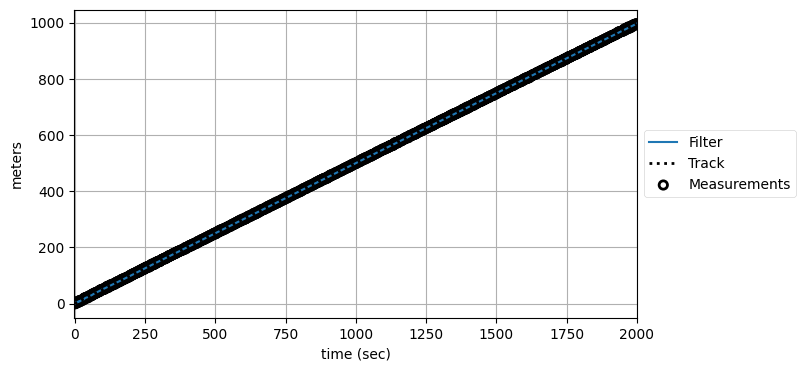

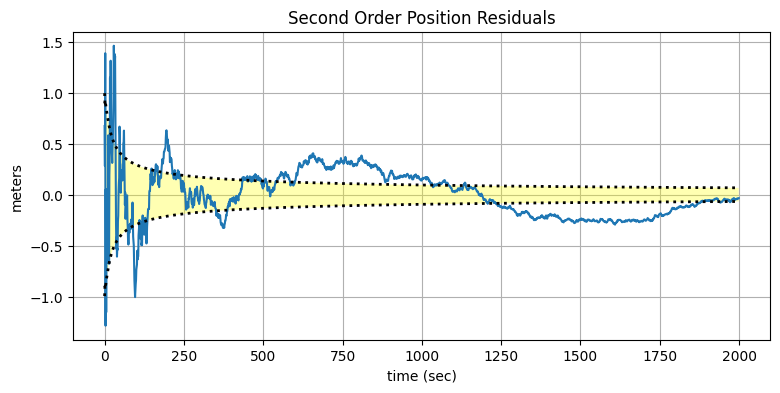

In [32]:
np.random.seed(32594)
xs2000, zs2000 = simulate_system(Q=0.0001, count=2000)

kf2 = SecondOrderKF(R, 0, dt=1)
data2000 = filter_data(kf2, zs2000)

plot_kf_output(xs2000, data2000.x, data2000.z)
plot_residuals(xs2000[:, 0], data2000, 0, 
               'Second Order Position Residuals',
               'meters') 

再次，剩余情节讲述了这个故事。 轨迹看起来非常好，但残差图显示过滤器在很长一段时间内都在发散。

你应该如何看待这一切？ 您可能会争辩说，最后一个情节对于您的应用程序来说“足够好”，也许确实如此。 但是我警告你，发散的过滤器并不总是会聚。 使用不同的数据集或性能不同的物理系统，您最终可能会得到一个越来越远离测量值的过滤器。

另外，让我们从数据拟合的角度来考虑这个问题。 假设我给你两点，并告诉你用一条直线拟合这些点。

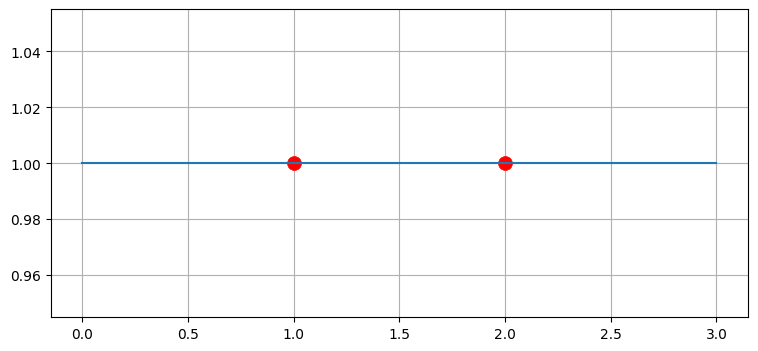

In [33]:
plt.scatter([1, 2], [1, 1], s=100, c='r')
plt.plot([0, 3], [1, 1]);

直线是唯一可能的答案。此外，答案是最佳的。如果我给你更多的分数，你可以使用最小二乘拟合来找到最佳线，并且答案在最小二乘意义上仍然是最佳的。

但是假设我告诉你要为这两个点拟合一个高阶多项式。这个问题有无数个答案。例如，无限数量的二阶抛物线通过这些点。当卡尔曼滤波器的阶数高于您的物理过程时，它也有无限数量的解决方案可供选择。答案不仅不是最佳的，而且经常出现分歧并且永远不会恢复。

为了获得最佳性能，您需要一个顺序与系统顺序匹配的过滤器。在许多情况下，这很容易做到——如果您正在设计一个卡尔曼滤波器来读取冰箱的温度计，那么零阶滤波器似乎是正确的选择。但是，如果我们要跟踪汽车，我们应该使用什么顺序呢？当汽车以恒定速度沿直线行驶时，一阶会很好地工作，但汽车会转弯、加速和减速，在这种情况下，二阶滤波器的性能会更好。这就是自适应过滤器一章中解决的问题。在那里，我们将学习如何设计一个过滤器，以适应被跟踪对象行为中不断变化的顺序。

话虽如此，只要您添加足够的过程噪声并保持离散化周期较小（每秒 100 个样本通常是局部线性的），低阶滤波器就可以跟踪高阶过程。结果不会是最佳的，但它们仍然非常好，我总是在尝试自适应滤波器之前先使用这个工具。让我们看一个加速的例子。首先，模拟。

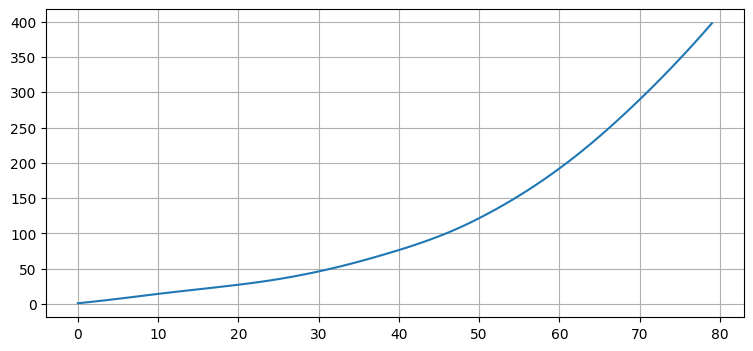

In [34]:
class ConstantAccelerationObject(object):
    def __init__(self, x0=0, vel=1., acc=0.1, acc_noise=.1):
        self.x = x0
        self.vel = vel
        self.acc = acc
        self.acc_noise_scale = acc_noise
    
    def update(self):
        self.acc += randn() * self.acc_noise_scale       
        self.vel += self.acc
        self.x += self.vel
        return (self.x, self.vel, self.acc)
  
R, Q = 6., 0.02
def simulate_acc_system(R, Q, count):
    obj = ConstantAccelerationObject(acc_noise=Q)
    zs = []
    xs = []
    for i in range(count):
        x = obj.update()
        z = sense(x, R)
        xs.append(x)
        zs.append(z)
    return np.asarray(xs), zs

np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)
plt.plot(xs[:, 0]);

现在我们将使用二阶过滤器过滤数据。

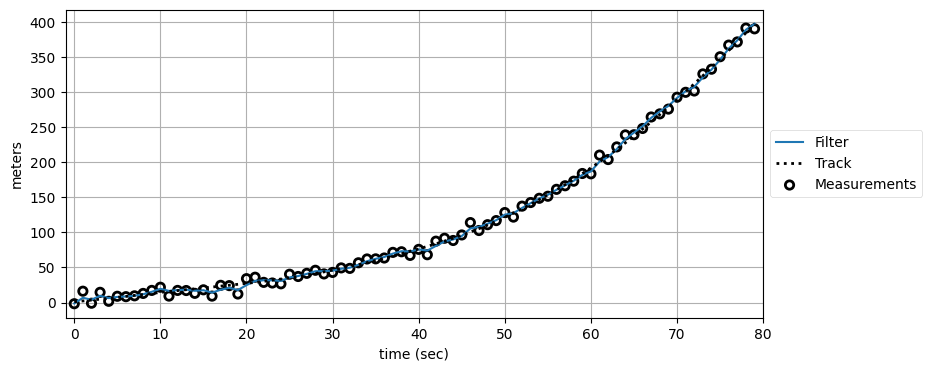

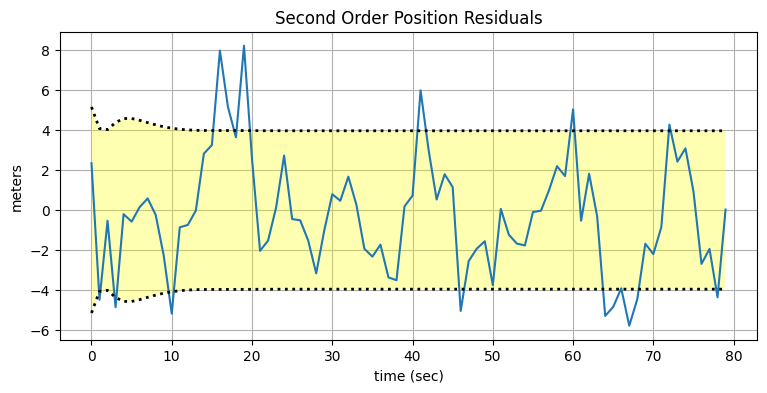

In [35]:
np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)

kf2 = SecondOrderKF(R, Q, dt=1)
data2 = filter_data(kf2, zs)

plot_kf_output(xs, data2.x, data2.z, aspect_equal=False)
plot_residuals(xs[:, 0], data2, 0, 
               'Second Order Position Residuals',
               'meters') 

我们可以看到过滤器的性能在过滤器的理论限制范围内。

现在让我们使用一个低阶过滤器。 正如已经证明的那样，低阶滤波器将滞后信号，因为它没有对加速度进行建模。 但是，我们可以（在一定程度上）通过增加过程噪声的大小来解释这一点。 过滤器将加速度视为过程模型中的噪声。 结果将是次优的，但如果设计得当，它不会发散。 选择额外过程噪声的数量并不是一门精确的科学。 您将不得不尝试具有代表性的数据。 在这里，我将它乘以 10，并且得到了很好的结果。

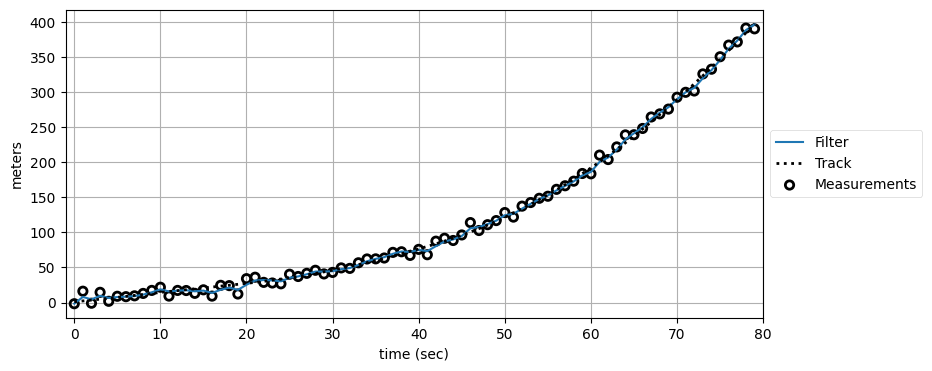

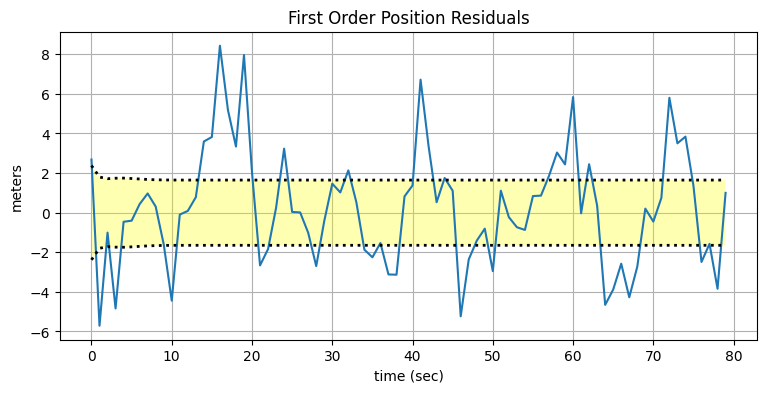

In [36]:
kf3 = FirstOrderKF(R, Q * 10, dt=1)
data3= filter_data(kf3, zs)

plot_kf_output(xs, data3.x, data3.z, aspect_equal=False)
plot_residuals(xs[:, 0], data3, 0, 
               'First Order Position Residuals',
               'meters') 

想想如果你让过程噪音比它需要的大很多倍会发生什么。 较大的过程噪声会告诉滤波器有利于测量，因此我们希望滤波器能够密切模拟测量中的噪声。 让我们来了解一下。

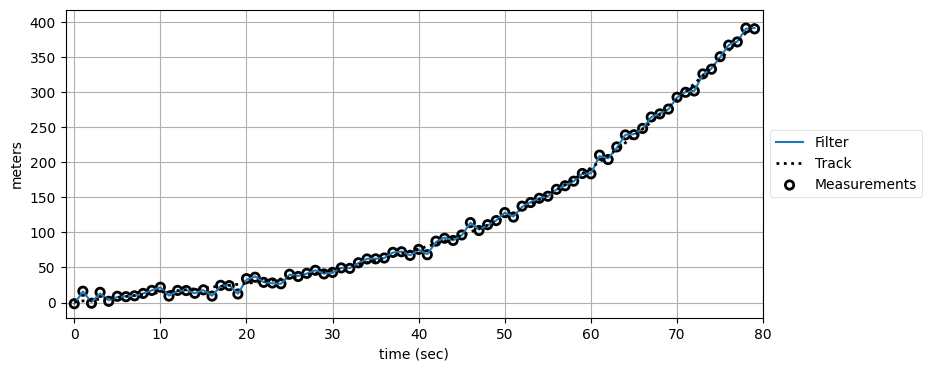

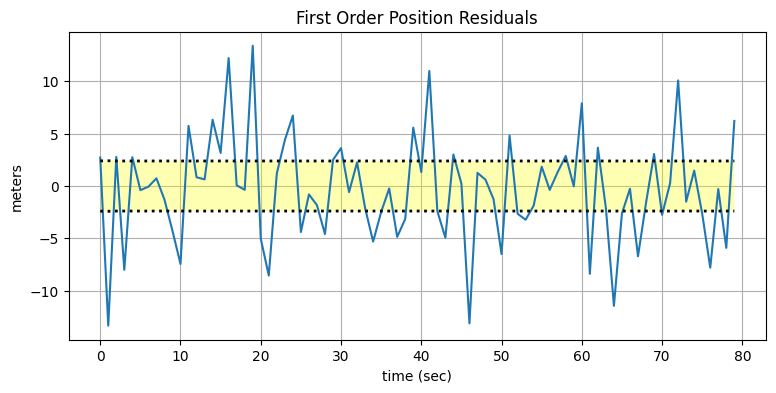

In [37]:
kf4 = FirstOrderKF(R, Q * 10000, dt=1)
data4 = filter_data(kf4, zs)

plot_kf_output(xs, data4.x, data4.z, aspect_equal=False)
plot_residuals(xs[:, 0], data4, 0, 
               'First Order Position Residuals',
               'meters') 

## Exercise: State Variable Design

正如我所提到的，您可以按照您选择的任何顺序将变量放在 $\mathbf x$ 中。 例如，您可以将一维恒定加速度定义为 $\mathbf x = \begin{bmatrix}\ddot x & x & \dot x\end{bmatrix}^\mathsf T$。 我无法想象你为什么想要那个订单，但这是可能的。

让我们做一些更合理的事情。 为二维运动的机器人设计一个二阶滤波器，其中 $\mathbf x = \begin{bmatrix}x & y & \dot x & \dot y \end{bmatrix}^\mathsf T$. In this chapter we have been using $\mathbf x = \begin{bmatrix}x & \dot x & y & \dot y \end{bmatrix}^\mathsf T$.

为什么要选择不同的排序？ 稍后您将看到，更改 $\mathbf x$ 的顺序会更改过滤器其余大部分矩阵的顺序。 根据您要检查的数据，例如 $\mathbf P$ 中的相关性，$\mathbf x$ 的各种排序可能会使检查变得更容易或更困难。

想想如何做到这一点。 需要改变什么？ 显然，您只需要更改卡尔曼滤波器矩阵即可反映这种新设计。

使用此样板代码在下面尝试一下：

```python

N = 30 # number of iterations
dt = 1.0 # time step
R_std = 0.35
Q_std = 0.04

sensor = PosSensor((0, 0), (2, .5), noise_std=R_std)
zs = np.array([sensor.read() for _ in range(N)])

tracker = KalmanFilter(dim_x=4, dim_z=2)
# assign state variables here

xs, ys = [], []
for z in zs:
    tracker.predict()
    tracker.update(z)
    xs.append(tracker.x[0])
    ys.append(tracker.x[1])
plt.plot(xs, ys);
```

### Solution

让我们从 $\mathbf F$ 开始。 通过一些练习，您应该能够只写出矩阵。 如果你觉得这很困难，那么写出 $\mathbf F$ 的方程组，对状态变量使用的变量进行排序。

$$
x = 1x + 0y + 1\dot x\Delta t + 0 \dot y\Delta t \\
y = 0x + 1y + 0\dot x\Delta t + 1 \dot y\Delta t \\
\dot x = 0x + 0y + 1\dot x\Delta t + 0 \dot y\Delta t \\
\dot y = 0x + 0y + 0\dot x\Delta t + 1 \dot y\Delta t 
$$

我们可以复制出系数得到

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$

状态噪音也需要改变周围的东西。 首先，弄清楚它应该如何安排状态变量排序。 如果您在矩阵中垂直和水平写入状态变量以查看它们如何配对，这会更容易。 这在 Jupyter notebook 中很难做到，所以我将在这里放弃它。

$$\mathbf Q = 
\begin{bmatrix}
\sigma_x^2 & \sigma_{xy} & \sigma_{x\dot x} & \sigma_{x\dot y} \\
\sigma_{yx} & \sigma_y^2 & \sigma_{y\dot x} & \sigma_{y\dot y} \\
\sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\
\sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2
\end{bmatrix}
$$

$x$ 和 $y$ 之间没有相关性，因此我们可以将两者都设置为零

$$\mathbf Q = 
\begin{bmatrix}
\sigma_x^2 & 0 & \sigma_{x\dot x} & 0 \\
0 & \sigma_y^2 & 0 & \sigma_{y\dot y} \\
\sigma_{\dot x x} & 0 & \sigma_{\dot x}^2 & 0 \\
0 & \sigma_{\dot y y} & 0 & \sigma_{\dot y}^2
\end{bmatrix}
$$

现在你看到了这个，你可以看到模式并且可能更快地设计 $\mathbf Q$。

`Q_discrete_white_noise` 生成一个具有不同顺序的矩阵，但我们可以从中复制项，我们将在下面的代码中看到。

Now let's design $\mathbf H$. It converts the state $\begin{bmatrix}x & y & \dot x & \dot y \end{bmatrix}^\mathsf T$ into the measurement $\mathbf z = \begin{bmatrix}z_x & z_y\end{bmatrix}^\mathsf T$.

$$
\begin{aligned}
\mathbf{Hx} &= \mathbf z \\
\begin{bmatrix}?&?&?&?\\?&?&?&?\end{bmatrix}\begin{bmatrix}x \\ y \\ \dot x \\ \dot y \end{bmatrix} &= \begin{bmatrix}z_x \\ z_y\end{bmatrix}
\end{aligned}
$$

现在应该很容易填写矩阵：

$$
\begin{bmatrix}1&0&0&0\\0&1&0&0\end{bmatrix}\begin{bmatrix}x \\ y \\ \dot x \\ \dot y \end{bmatrix} = \begin{bmatrix}z_x \\ z_y\end{bmatrix}
$$

测量 $\mathbf z = \begin{bmatrix}z_x & z_y\end{bmatrix}^\mathsf T$ 没有改变，所以 $\mathbf R$ 没有改变。

最后，$\mathbf P$。 它使用与 $\mathbf Q$ 相同的顺序，因此它已经为我们设计好了。

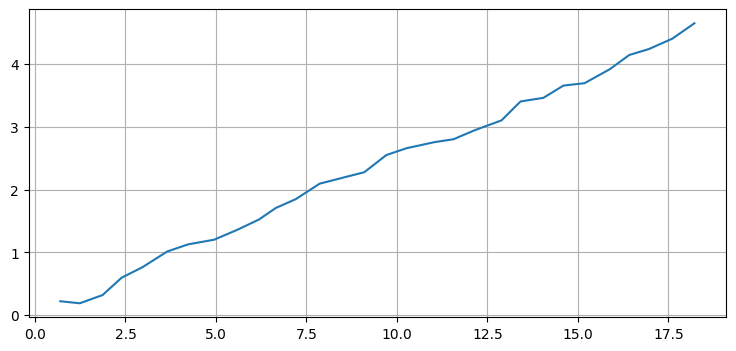

In [38]:
N = 30 # number of iterations
dt = 1.0 # time step
R_std = 0.35
Q_std = 0.04

M_TO_FT = 1 / 0.3048

sensor = PosSensor((0, 0), (2, .5), noise_std=R_std)
zs = np.array([sensor.read() for _ in range(N)])

tracker = KalmanFilter(dim_x=4, dim_z=2)

tracker.F = np.array([[1, 0, dt,  0],
                      [0, 1,  0, dt],
                      [0, 0,  1,  0],
                      [0, 0,  0,  1]])

tracker.H = np.array([[M_TO_FT, 0, 0, 0],
                      [0, M_TO_FT, 0, 0]])

tracker.R = np.eye(2) * R_std**2
q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
tracker.Q[0,0] = q[0,0]
tracker.Q[1,1] = q[0,0]
tracker.Q[2,2] = q[1,1]
tracker.Q[3,3] = q[1,1]
tracker.Q[0,2] = q[0,1]
tracker.Q[2,0] = q[0,1]
tracker.Q[1,3] = q[0,1]
tracker.Q[3,1] = q[0,1]

tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

xs, ys = [], []
for z in zs:
    tracker.predict()
    tracker.update(z)
    xs.append(tracker.x[0])
    ys.append(tracker.x[1])
plt.plot(xs, ys);

## Detecting and Rejecting Bad Measurement

卡尔曼滤波器无法检测和拒绝不良测量。 假设您正在跟踪飞机，并且您收到距离飞机当前位置 100 公里的测量值。 如果您使用该值调用更新，则新估计值将彻底偏向测量值。

我将运行一个模拟来给我们一个具体的例子。 在 100 个 epoch 之后，我将使用等于当前位置两倍的测量值进行更新。 `filterpy.common` 提供了 `kinematic_kf`，它创建了一个任意维度和顺序的线性运动学滤波器。 我将在这里使用它来保持代码整洁，我不会在本书的其余部分中使用它，因为我希望你能获得大量编写过滤器的练习。

In [39]:
from filterpy.common import kinematic_kf

kf = kinematic_kf(dim=2, order=1, dt=1.0, order_by_dim=False)
kf.Q = np.diag([0, 0, .003, .003])
kf.x = np.array([[1., 1., 0., 0.]]).T
kf.R = np.diag([0.03, 0.21]) # use different errors

for i in range(101):
    kf.predict()
    kf.update(np.array([[i*.05, i*.05]])) # around 200 kph

p0 = kf.x[0:2]

kf.predict()
prior = kf.x
z = kf.x[0:2]*2
kf.update(z)
p1 = kf.x[0:2]

# compute error of measurement from prior
y = np.abs(z - kf.H @ prior)
dist = np.linalg.norm(y)

np.set_printoptions(precision=2, suppress=True)

print(f'bad measurement       : {z.T} km')
print(f'before bad measurement: {p0.T} km')
print(f'after bad measurement : {p1.T} km')
print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
print(f'distance from prior   : {dist:.1f} km')

bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[7.84 7.01]] km
estimate shift        : 3.4 km
distance from prior   : 7.1 km


`kinematic_kf`？那是什么？ `filterpy.common` 提供 `kinematic_kf` 允许您创建任意维度和顺序的线性运动学滤波器。我没有在本书中使用它，因为我希望你获得很多创建卡尔曼滤波器的经验。我在这里使用它只是为了使我的示例简短，并向您展示库的这一部分。

回到主题。如您所见，估计值跳跃了 3.4 公里，预测（先前）与测量值之间的误差超过 7 公里。

我们可以做些什么来避免这种情况？我们的第一个想法可能是添加一个检查，如果先验距离测量值很远。为什么是先前的估计而不是当前的估计？因为在更新之后，估计现在可能非常接近错误的测量值，尽管在这种情况下不是。

请注意，虽然我可以写 `prior[0:2] - z` 来得到错误，但我使用数学上正确的 $\mathbf z - \mathbf{Hx}$ 来计算错误。这只是为了说明；卡尔曼滤波器类将创新存储在“KalmanFilter.y”中。我使用它而不是我上面计算的值来说明这一点：

In [40]:
print(f'error = {np.linalg.norm(kf.y):.1f} km, at a speed of {dist*3600:.0f} kph')

error = 7.1 km, at a speed of 25710 kph


在这个例子中，测量距离预测位置近 7 公里。 这听起来很“远”。 是吗？ 如果单位是公里，更新率为1秒，可能会很远； 没有飞机能够以超过 25000 公里/小时的速度飞行这个错误所暗示的。 如果单位是厘米并且纪元是 1 分钟，它可能会小得离谱。

我们可以添加一个检查，将飞机的性能限制考虑在内：

```
vel = y / dt
if vel >= MIN_AC_VELOCITY and vel <= MAX_AC_VELOCITY:
    kf.update()
```
 
您认为这是一个合理且稳健的解决方案吗？ 在进一步阅读之前，尽可能多地提出反对意见。


这对我来说不是很满意。 假设我们刚刚用猜测的位置初始化了过滤器； 我们会丢弃好的测量结果，并且永远不会开始过滤。 其次，这忽略了我们对传感器和过程错误的了解。 卡尔曼滤波器在 $\mathbf P$ 中保持其当前精度。 如果 $\mathbf P$ 暗示 $\sigma_x = 10$ 米，并且测量距离为 1 公里，那么显然测量结果很差，因为它与先验相差 100 个标准差。

让我们绘制 $\mathbf P$。 我将绘制第一、第二和第三个标准差。

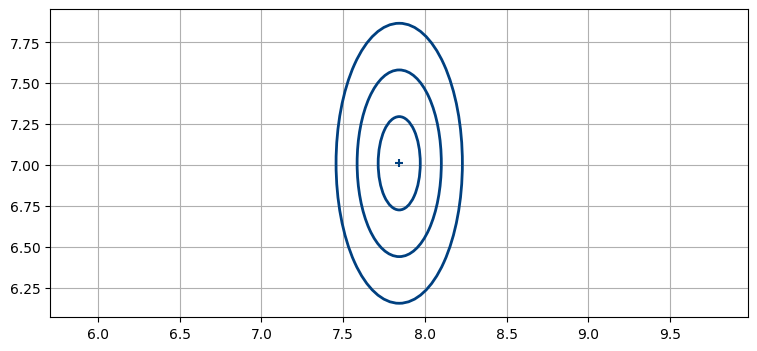

In [41]:
x, P = kf.x[0:2], kf.P[0:2, 0:2]
plot_covariance_ellipse(x, P, std=[1,2,3])

在前面的章节中，$\mathbf P$ 是一个圆圈，而不是一个椭圆。 在我的代码中，我设置了 $\mathbf R = \bigl[ \begin{smallmatrix}0.03 & 0 \\ 0 & 0.15\end{smallmatrix}\bigl ]$，它给出了 $y$ 的测量值是 $ 误差的 5 倍 x$。 这有点人为，但在随后的章节中，几乎所有的协方差都是椭圆的，这是有充分理由的。

想想这意味着什么。 统计数据告诉我们，99% 的测量值落在 3 个标准差以内； 这意味着所有测量值的 99% 应该在这个椭圆内。 让我们用椭圆绘制测量值。

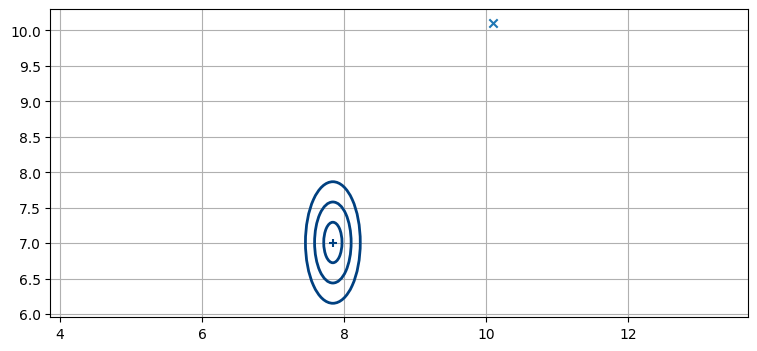

In [42]:
plot_covariance_ellipse(x, P, std=[1,2,3])
plt.scatter(z[0], z[1], marker='x');

显然，测量远远超出了先验的协方差；我们可能想认为这是一个不好的测量，而不是使用它。我们将如何做到这一点？

第一个想法是提取 $x$ 和 $y$ 的标准差并编写一个简单的 if 语句。这里我将使用 `KalmanFilter` 类的另一个特性。 `residual_of` 方法计算与先验相比的残差。在这种情况下我不需要使用它，因为 `kf.y` 已经通过调用 `update()` 分配了，但是如果我们要丢弃测量值，`update()` 将不会被调用并且 `kf .y` 将包含上一个时代的创新。

首先，让我们介绍两个术语。我们正在讨论**门控**。 **gate** 是一个公式或算法，用于确定测量结果的好坏。只有好的测量值才能通过大门。这个过程称为门控。

在实践中，测量不是纯高斯的，因此 3 个标准差的门可能会丢弃一些好的测量。我将很快详细说明，现在我们将使用 4 个标准差

In [43]:
GATE_LIMIT = 4.
std_x = np.sqrt(P[0,0])
std_y = np.sqrt(P[1,1])
y = kf.residual_of(z)[:,0]

if y[0] > GATE_LIMIT * std_x or y[1] > GATE_LIMIT * std_y:
    print(f'discarding measurement, error is {y[0]/std_x:.0f} std, {y[1]/std_y:.0f} std')
    
print('y   is', y)
print(f'std is {std_x:.2f} {std_y:.2f}')

discarding measurement, error is 39 std, 18 std
y   is [5.05 5.05]
std is 0.13 0.29


我们看到误差大约相差 39 和 18 个标准差。 这够好吗？

或许。 但是，请注意 if 语句在椭圆周围形成一个矩形区域。 在下图中，我绘制了一个明显在 3 std 椭圆之外的测量值，但会被门接受，另一个测量值正好位于 3 std 边界上。

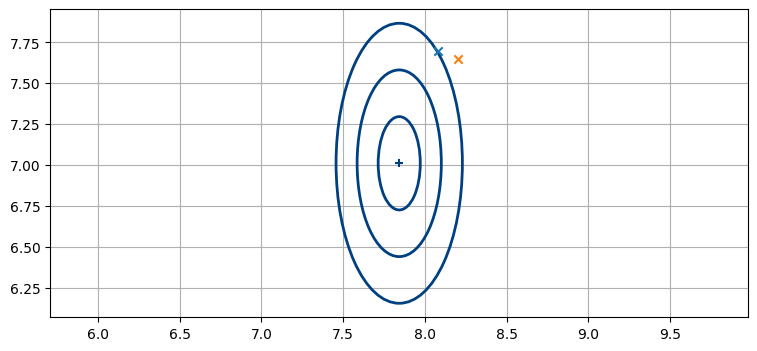

In [44]:
plot_covariance_ellipse(x, P, std=[1,2,3])
plt.scatter(8.08, 7.7, marker='x')
plt.scatter(8.2, 7.65, marker='x');

有定义此门的替代方法。 **马哈拉诺比斯距离**是一个点与分布的距离的统计量度。 在我们开始定义和数学之前，让我们计算一些点的马氏距离。 `filterpy.stats` 实现了 `mahalanobis()`。

In [45]:
from filterpy.stats import mahalanobis
m = mahalanobis(x=z, mean=x, cov=P)
print(f'mahalanobis distance = {m:.1f}')

mahalanobis distance = 20.6


在不知道单位的情况下，我们可以将其与分别以 $x$ 和 $y$、39 和 18 计算的标准差误差进行比较，并看到它相当接近。 让我们看看我们在上面绘制的点上得到了什么。

In [46]:
print(f'mahalanobis distance = {mahalanobis(x=[8.08, 7.7], mean=x, cov=P):.1f}')
print(f'mahalanobis distance = {mahalanobis(x=[8.2, 7.65], mean=x, cov=P):.1f}')

mahalanobis distance = 3.0
mahalanobis distance = 3.6


正如我们将看到的，马氏距离计算标量标准偏差*距离*点到分布，很像欧几里得距离计算从一个点到另一个点的标量距离。

上面的单元格证明了这一点。 位于 3 std 边界上的点的马氏距离为 3.0，椭圆外的点的值为 3.6 std。

我们如何计算马氏距离？ 它被定义为

$$D_m= \sqrt{(\mathbf x-\mu)^\mathsf T \mathbf S^{-1} (\mathbf x-\mu)}$$

注意这与欧几里得距离有多么相似，我们可以写成：

$$D_e= \sqrt{(\mathbf x-\mathbf y)^\mathsf T (\mathbf x-\mathbf y)}$$

事实上，如果协方差 $\mathbf S$ 是单位矩阵，则马氏距离与欧几里得距离相同。 你应该能够看到它是如何与线性代数一起工作的：单位矩阵的逆是单位矩阵，所以我们有效地将这些项乘以 1。直观地考虑一下。 如果每个维度的标准差为 1，则围绕均值的半径为 1 的圆上的任意点都将位于第 1 个标准圆上，并且在欧几里得度量中也相距 1 *unit*。

这暗示了另一种解释。 如果协方差矩阵是对角线，那么我们可以将马氏距离视为*缩放*欧几里得距离，其中每个项都由对角线中的协方差缩放。

$$D_m = \sqrt{\sum_{i-1}^N \frac{(x_i - \mu_i)^2}{\sigma_i}}$$

In 2D that would be 

$$D_m = \sqrt {\frac{1}{\sigma_x^2}(x_0 - x_1)^2 + \frac{1}{\sigma_y^2}(y_0 - y_1)^2}$$

这应该让您深入了解马氏距离的方程。 您不能除以矩阵，但乘以逆矩阵*实际上*是相同的，在手波的意义上。 乘以每边的差 $\mathbf y = \mathbf x - \mathbf \mu$ 得到由协方差缩放的平方范数： $\mathbf y^\mathsf T \mathbf S^{-1}\mathbf y ^\mathsf T$。 协方差项都是平方的，所以最后取平方根会给我们带来一个标量距离，它是由协方差缩放的欧几里得距离。

### Gating and Data Association Strategies

上面的两个门因其形状而在一些文献中被称为矩形门和椭圆形门。还有更多的选择我不会在这里探讨。例如，机动门用于定义对象可以机动的区域，同时考虑到对象的当前速度和机动能力。例如，一架战斗机将有一个机动门，其形状很像一个圆锥体，在其当前的行进方向前方突出。汽车将有一个小得多的 2D 饼形切片形状投射在它前面。一艘船的切片要窄得多，因为它快速转弯或加速的能力很小。

您应该使用哪种门控技术？没有单一的答案。很大程度上取决于问题的维度以及您拥有多少计算能力。矩形门的计算成本非常低，机动门也不会差很多，但椭圆门在更高维度上可能会很昂贵。但是，随着尺寸的增加，椭圆体和矩形浇口之间的相对面积差异会显着增加。

这比你可能意识到的更重要。每次测量都有噪音。一个虚假的测量值可能会落入我们的门内，导致我们接受它。越过椭球的区域越大，门通过错误测量的概率就越大。我不会在这里做数学，但在 5 维中，矩形门接受错误测量的可能性是椭圆体的两倍。

如果计算时间是一个问题，并且您有许多虚假测量，您可以采用两门方法。第一个门是大的和矩形的，用作第一次通过丢弃明显不好的测量。通过该门的少数测量然后进行更昂贵的马氏距离计算。如果您在现代桌面处理器上运行，那么这些矩阵乘法的时间并不重要，但如果您在具有适度浮点性能的嵌入式芯片上运行，则可能很重要。

数据关联是一个庞大的话题，需要自己的书。典型的例子是用雷达跟踪。雷达在每次扫描时检测到多个信号。从那里我们需要形成飞机轨迹，并拒绝噪声测量。这是一个非常困难的问题。假设第一次扫描获得 5 次测量。我们将创建 5 个潜在轨道。在下一次扫描中，我们得到 6 个测量值。我们可以将任何第一次测量与任何第二次测量结合起来，为我们提供 30 个潜在轨道。但是，也有可能这些都是我们在上次扫描中没有看到的新飞机，所以我们又多了 6 个航迹。仅仅几个时期之后，我们就达到了数百万，然后是数十亿的潜在轨道。

鉴于这个数十亿轨道的列表，我们可以计算每个轨道的分数。我将在下一节中提供数学。但是，可视化在 3 个 epoch 上形成“Z”形的轨迹。没有飞机可以像那样机动，所以我们认为它是真实的可能性非常低。另一条轨道形成一条直线，但估算的速度为 10,000 kph。这也是非常不可能的。另一条时速 200 公里的赛道曲线。这个概率很大。

因此，跟踪变成了门控、数据关联和修剪的问题。例如，假设第二次雷达扫描刚刚发生。我是否将所有可能的组合组合成一个轨道？我可能不应该。如果点 1，扫描 1 用点 3，扫描 2 估算 200kph 的速度，我们应该从它形成一个轨迹。如果速度是 5000 公里/小时，我们不应该打扰；我们知道，这条赛道的可能性很小，以至于不可能。然后，随着轨道的增长，我们将为它们定义明确的椭圆或机动门，并且我们可以对与轨道相关联的测量更具选择性。

有协会计划。我们可以选择仅将测量与一个轨道相关联。或者，我们可以选择将测量与多个轨道相关联，这反映了我们不确定它属于哪个轨道。例如，飞机航迹可以从雷达的角度穿过。随着飞机接近，将单个测量与两架飞机中的一架相关联可能变得不确定。您可以在短时间内将测量分配给两个轨道。当您收集更多测量值时，您可以返回并根据新信息更可能更改分配。

“十亿”并没有开始捕捉这暗示的组合爆炸。仅仅几秒钟后，您将耗尽计算机内存，再过一点，您将需要宇宙中的每个原子来代表所有潜在的轨道。所以一个实用的算法需要积极地修剪轨迹。这种修剪需要额外的计算能力。

本书后面的章节提供了这个问题的现代答案，*粒子过滤器*，它通过统计采样解决了组合爆炸。这是我最喜欢解决这个问题的方法，所以我不会写更多关于我在本节中讨论的技术。我并不完全了解该领域的最新研究，因此如果您试图解决需要跟踪多个对象或处理多个虚假测量的问题，请自行研究。粒子过滤器有其自身的困难和局限性。

我将向您指出一些书籍和研究人员。 Samuel S. Blackman 的“Multiple-Target Tracking with Radar Application”是我读过的关于该主题的最清晰的书面书籍，尽管它已过时（1986 年）。 Yaakov Bar-Shalom 就该主题撰写了大量文章。苏哈希查拉等。 al “对象跟踪基础”是一部相当现代的作品，涵盖了各种方法。这本书在数学上相当严谨。过滤器呈现为代表各种贝叶斯公式的积分集合，您可以将其转换为工作算法。如果你已经掌握了本书中的所有数学知识，它是可读的，但并不容易。 Lawrence D. Stone 的“贝叶斯多目标跟踪”将其视为贝叶斯推理问题，正如我所拥有的，但也是相当理论化的，在那里你被轻松地告诉你找到一个复杂积分的最大值，在实践中你可能会解决使用一个粒子过滤器。

回到我们的简单问题——跟踪一个偶尔出现错误测量的对象。 那应该如何实施？ 这相当简单； 如果测量结果不好，丢弃它并且不要调用更新。 这将导致您连续两次调用`predict()`，这很好。 您的不确定性会增加，但一些错过的更新通常不会导致问题。

你应该为你的门使用什么截止值？ 我不知道。 理论说 3 标准，但实践却不然。 您将需要进行实验。 收集数据，使用各种门对其运行过滤器，然后查看什么值可以提供最佳结果。 在下一节中，我会给你一些数学来评估过滤器的性能。 也许您发现您需要接受所有小于 4.5 标准的测量值。 我观看了 NASA 的视频，他们说他们使用了大约 5-6 标准的门。 这取决于您的问题和数据。

## Evaluating Filter Performance

为模拟情况设计卡尔曼滤波器很容易。您知道您在流程模型中注入了多少噪音，因此您指定 $\mathbf Q$ 具有相同的值。您还知道测量模拟中有多少噪声，因此测量噪声矩阵 $\mathbf R$ 的定义同样简单。

在实践中，设计更加临时。真正的传感器很少按照规范执行，而且它们很少以高斯方式执行。他们也很容易被环境噪音所迷惑。例如，电路噪声会导致电压波动，从而影响传感器的输出。创建过程模型和噪音更加困难。为汽车建模非常困难。转向导致非线性行为，轮胎打滑，人们刹车和加速足以导致轮胎打滑，风将汽车推离赛道。最终结果是卡尔曼滤波器是系统的*不精确*模型。这种不精确性会导致次优行为，在最坏的情况下会导致过滤器完全发散。

由于未知数，您将无法分析计算过滤器矩阵的正确值。您将从做出可能的最佳估计开始，然后针对各种模拟和真实数据测试您的过滤器。您对性能的评估将指导您对矩阵进行哪些更改。我们已经做了一些——我已经向你展示了 $\mathbf Q$ 太大或太小的影响。

现在让我们考虑更多访问性能的分析方法。如果卡尔曼滤波器性能最佳，它的估计误差（真实状态和估计状态之间的差异）将具有以下属性：

     1.估计误差的均值为零
     2. 其协方差由卡尔曼滤波器的协方差矩阵描述
    
### Normalized Estimated Error Squared (NEES)

第一种方法是最强大的，但只能在模拟中使用。 如果您正在模拟一个系统，您就会知道它的真正价值，或“基本事实”。 然后将系统在任何步骤的误差计算为基本事实 ($\mathbf x$) 和过滤器的状态估计 ($\hat{\mathbf x}$) 之间的差异是微不足道的：

$$\tilde{\mathbf x} = \mathbf x - \hat{\mathbf x}$$

然后我们可以将*归一化估计误差平方* (NEES) 定义为

$$\epsilon = \tilde{\mathbf x}^\mathsf T\mathbf P^{-1}\tilde{\mathbf x}$$

为了理解这个等式，让我们看一下状态的维度是否为一。 在那种情况下，x 和 P 都是标量，所以

$$\epsilon = \frac{x^2}{P}$$

如果不清楚，请回想如果 $a$ 是标量，则 $a^\mathsf T = a$ 并且 $a^{-1} =\frac{1}{a}$。

因此，随着协方差矩阵变小，对于相同的误差，NEES 会变大。 协方差矩阵是滤波器对其误差的估计，因此如果它相对于估计误差较小，那么它的性能会比它相对于相同的估计误差大时更差。

这个计算给了我们一个标量结果。 如果$\mathbf x$是维度($n \times 1$)，那么计算的维度是($1 \times n$)($n \times n$)($n \times 1$) = ($1 \乘以 1$)。 我们如何处理这个数字？

数学超出了本书的范围，但形式为 $\tilde{\mathbf x}^\mathsf T\mathbf P^{-1}\tilde{\mathbf x}$ 的随机变量据说是 * 卡方分布有 n 个自由度*，因此序列的期望值应该是 $n$。 Bar-Shalom [1] 对这个话题进行了很好的讨论。

简单来说，取所有 NEES 值的平均值，它们应该小于 x 的维数。 让我们看看本章前面的一个例子：

In [47]:
from scipy.linalg import inv

def NEES(xs, est_xs, Ps):
    est_err = xs - est_xs
    err = []
    for x, p in zip(est_err, Ps):
        err.append(x.T @ inv(p) @ x)
    return err

In [48]:
R, Q = 6., 0.02
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)
kf2 = SecondOrderKF(R, Q, dt=1)
est_xs, ps, _, _ = kf2.batch_filter(zs)

nees = NEES (xs, est_xs, ps)
eps = np.mean(nees)

print(f'mean NEES is: {eps:.4f}')
if eps < kf2.dim_x:
    print('passed')
else:
    print('failed')

mean NEES is: 0.8893
passed


`NEES` 实现了FilterPy； 访问它

```python
from filterpy.stats import NEES
```
这是过滤器性能的一个很好的衡量标准，应尽可能使用，尤其是在生产代码中，当您需要在运行时评估过滤器时。 在设计过滤器时，我仍然更喜欢绘制残差，因为它可以让我更直观地了解正在发生的事情。

但是，如果您的模拟保真度有限，那么您需要使用另一种方法。

### Likelihood Function

在统计学中，可能性与概率非常相似，但存在对我们很重要的细微差别。 *probability* 是某事发生的可能性——比如一个公平骰子在五次掷骰中掷出 3 次 6 的概率是多少？ *可能性*提出了相反的问题 - 假设一个骰子在 5 次滚动中滚动了 3 次 6，那么该骰子是公平的可能性是多少？

我们首先在**离散贝叶斯**一章中讨论了似然函数。在这些过滤器的上下文中，似然度是测量给定当前状态的可能性的度量。

这对我们很重要，因为我们有滤波器输出，并且我们想知道它在给定高斯噪声和线性行为的假设下表现最佳的可能性。如果可能性很低，我们知道我们的假设之一是错误的。在**自适应过滤**一章中，我们将学习如何利用这些信息来改进过滤器；在这里，我们将只学习进行测量。

滤波器的残差和系统不确定性定义为

$$\begin{aligned}
\mathbf y &= \mathbf z - \mathbf{H \bar x}\\
\mathbf S &= \mathbf{H\bar{P}H}^\mathsf T + \mathbf R
\end{aligned}
$$

鉴于这些，我们可以计算似然函数

$$
\mathcal{L} = \frac{1}{\sqrt{2\pi S}}\exp [-\frac{1}{2}\mathbf y^\mathsf T\mathbf S^{-1}\mathbf y]$$

这可能看起来很复杂，但请注意指数是高斯方程。 这表明实施

```python
from scipy.stats import multivariate_normal
hx = (H @ x).flatten()
S = H @ P @ H.T  + R
likelihood = multivariate_normal.pdf(z.flatten(), mean=hx, cov=S)
```

在实践中，情况会有所不同。可能性很难用数学方法处理。计算和使用 *log-likelihood* 是很常见的，它只是可能性的自然对数。这有几个好处。首先，日志是严格递增的，它在应用函数的同一点达到最大值。如果你想找到一个函数的最大值，你通常取它的导数；可能很难找到某个任意函数的导数，但找到 $\frac{d}{dx} log(f(x))$ 很简单，结果与 $\frac{d}{dx 相同} f(x)$。我们在本书中没有使用这个属性，但是在对过滤器进行分析时它是必不可少的。

当调用 `update()` 时会为您计算似然度和对数似然度，并且可以通过 'log_likelihood' 和 `likelihood` 数据属性访问。让我们看一下：我将在预期范围内使用多个测量值运行过滤器，然后注入远离预期值的测量值：

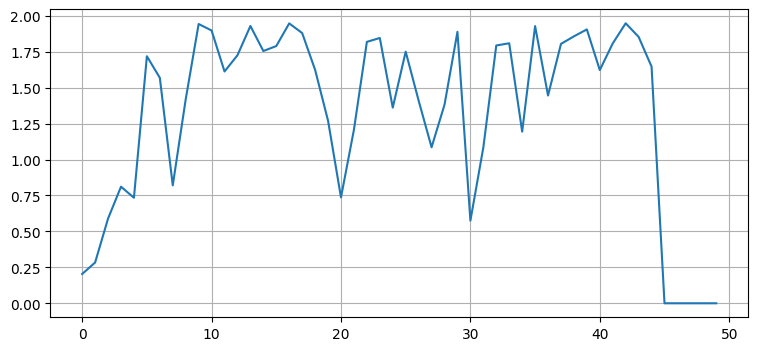

In [49]:
R, Q = .05, 0.02
xs, zs = simulate_acc_system(R=R, Q=Q, count=50)
zs[-5:-1] = [100, 200, 200, 200] # bad measurements, bad!

kf = SecondOrderKF(R, Q, dt=1, P=1)
s = Saver(kf)
kf.batch_filter(zs, saver=s)
plt.plot(s.likelihood);

随着滤波器在前几次迭代中收敛，可能性变得更大。 在那之后，可能性会反弹，直到它到达坏的测量值，此时它变为零，这表明如果测量值是有效的，那么过滤器不太可能是最优的。

看看对数似然有多明显地说明了过滤器在哪里“坏”了。

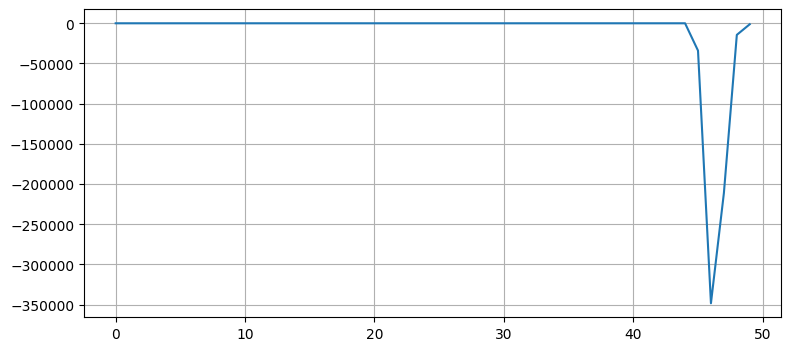

In [50]:
plt.plot(s.log_likelihood);

为什么最后会归零？ 在阅读答案之前考虑一下。 滤波器通过将状态移动到接近测量值来开始适应新的测量值。 残差变小，因此状态和残差一致。

## Control Inputs

在**离散贝叶斯**一章中，我介绍了使用控制信号来提高滤波器性能的概念。 我们没有假设对象继续移动，而是使用我们对控制输入的了解来预测对象的位置。 在**单变量卡尔曼滤波器**一章中，我们使用了相同的想法。 卡尔曼滤波器的预测方法读

```python
def predict(pos, movement):
    return (pos[0] + movement[0], pos[1] + movement[1])
```
在上一章中，我们了解到状态预测的方程是：

$$\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}$$

我们的状态是一个向量，所以我们需要将控制输入表示为一个向量。 这里 $\mathbf{u}$ 是控制输入，$\mathbf{B}$ 是将控制输入转换为 $\mathbf x$ 的变化的矩阵。 让我们考虑一个简单的例子。 假设我们正在控制的机器人的状态是 $x = \begin{bmatrix} x & \dot x\end{bmatrix}$，并且控制输入是命令速度。 这给了我们一个控制输入

$$\mathbf{u} = \begin{bmatrix}\dot x_\mathtt{cmd}\end{bmatrix}$$

为简单起见，我们假设机器人可以立即响应对此输入的更改。 这意味着 $\Delta t$ 秒后的新位置和速度将是

$$\begin{aligned}x &= x + \dot x_\mathtt{cmd} \Delta t \\
\dot x &= \dot x_\mathtt{cmd}\end{aligned}$$

我们需要用 $\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}$ 的形式来表示这组方程。

我将使用 $\mathbf{Fx}$ 项来提取顶部方程的 $x$，以及其余的 $\mathbf{Bu}$ 项，如下所示：



$$\begin{bmatrix}x\\\dot x\end{bmatrix} = \begin{bmatrix}1 & 0\\0 & 0 \end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix} +
\begin{bmatrix}\Delta t \\ 1\end{bmatrix}\begin{bmatrix}\dot x_\mathtt{cmd}\end{bmatrix}
$$


这是一个简化； 典型的控制输入是转向角的变化和加速度的变化。 这引入了非线性，我们将在后面的章节中学习处理这些非线性。

卡尔曼滤波器的其余部分将照常设计。 到目前为止，您已经多次看到此内容，因此这里不做进一步评论，仅举一个例子。

[[10.  0.]
 [ 0. 10.]]


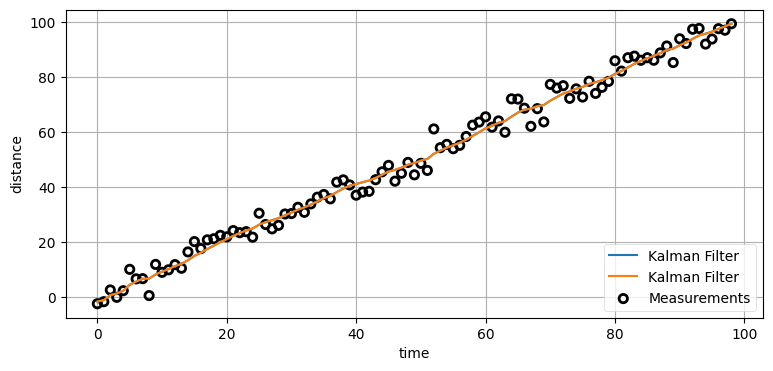

In [51]:
dt = 1.
R = 3.
kf = KalmanFilter(dim_x=2, dim_z=1, dim_u = 1)
kf.P *= 10
kf.R *= R
kf.Q = Q_discrete_white_noise(2, dt, 0.1)
kf.F = np.array([[1., 0], [0., 0.]])
kf.B = np.array([[dt], [ 1.]])
kf.H = np.array([[1., 0]])
print(kf.P)

zs = [i + randn()*R for i in range(1, 100)]
xs = []
cmd_velocity = np.array([1.])
for z in zs:
    kf.predict(u=cmd_velocity)
    kf.update(z)
    xs.append(kf.x[0])

plt.plot(xs, label='Kalman Filter')
plot_measurements(zs)
plt.xlabel('time')
plt.legend(loc=4)
plt.ylabel('distance');

## Sensor Fusion

在 g-h 滤波器一章的早期，我们讨论了为两种尺度设计一个滤波器，一种是准确的，一种是不准确的。我们确定我们应该始终包含来自不准确过滤器的信息——我们永远不应该丢弃任何信息。因此，考虑我们有两个传感器测量系统的情况。我们如何将它纳入我们的卡尔曼滤波器？

假设我们在铁路上有火车或手推车。它有一个连接在车轮上的传感器，用于计算转数，可以将其转换为沿轨道的距离。然后，假设我们有一个类似 GPS 的传感器，我称之为“位置传感器”，安装在火车上，用于报告位置。我将在下一节解释为什么我不只使用 GPS。因此，我们有两个测量值，都报告沿轨道的位置。进一步假设车轮传感器的精度为1m，位置传感器的精度为10m。我们如何将这两个测量值组合到一个过滤器中？这可能看起来很做作，但飞机使用传感器融合来融合来自 GPS、INS、多普勒雷达、VOR、空速指示器等传感器的测量值。

惯性系统的卡尔曼滤波器非常困难，但融合来自两个或多个传感器的数据提供相同状态变量（如位置）的测量值却非常容易。相关矩阵是测量矩阵$\mathbf H$。回想一下，这个矩阵告诉我们如何将卡尔曼滤波器的状态 $\mathbf x$ 转换为测量值 $\mathbf z$。假设我们决定我们的卡尔曼滤波器状态应该包含火车的位置和速度，所以

$$ \mathbf x = \begin{bmatrix}x \\ \dot x\end{bmatrix}$$

我们有两个位置测量值，因此我们将测量向量定义为来自车轮和位置传感器的测量值的向量。

$$ \mathbf z = \begin{bmatrix}z_{wheel} \\ z_{ps}\end{bmatrix}$$

所以我们必须设计矩阵 $\mathbf H$ 来将 $\mathbf x$ 转换为 $\mathbf z$ 。 它们都是位置，所以转换无非就是乘以一：

$$ \begin{bmatrix}z_{wheel} \\ z_{ps}\end{bmatrix} = \begin{bmatrix}1 &0 \\ 1& 0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}$$

为了更清楚，假设轮子报告的不是位置而是轮子的转数，其中 1 转产生 2 米的行程。 在这种情况下，我们会写

$$ \begin{bmatrix}z_{rot} \\ z_{ps}\end{bmatrix} = \begin{bmatrix}0.5 &0 \\ 1& 0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}$$

现在我们必须设计测量噪声矩阵$\mathbf R$。 假设位置的测量方差是车轮方差的两倍，车轮的标准偏差是 1.5 米。 这给了我们

$$
\begin{aligned}
\sigma_{wheel} &=  1.5\\
\sigma^2_{wheel} &= 2.25 \\ 
\sigma_{ps} &= 1.5*2 = 3 \\
\sigma^2_{ps} &= 9.
\end{aligned}
$$

这几乎就是我们的卡尔曼滤波器设计。 我们需要为 $\mathbf Q$ 进行设计，但这对于我们是否进行传感器融合是不变的，所以我将选择一些任意值。

所以让我们运行这个设计的模拟。 我将假设速度为 10 m/s，更新率为 0.1 秒。

fusion std: 1.647


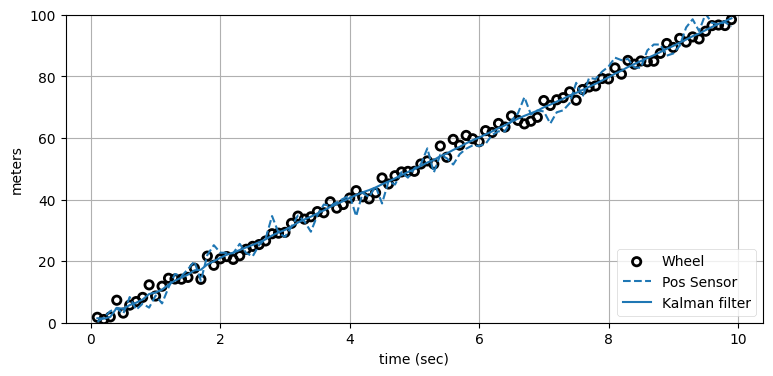

In [52]:
from numpy import array, asarray
import numpy.random as random

def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
    dt = 0.1
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.F = array([[1., dt], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.Q *= array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * 0.02
    kf.P *= 100
    kf.R[0, 0] = wheel_sigma**2
    kf.R[1, 1] = ps_sigma**2 
    s = Saver(kf)

    random.seed(1123)
    for i in range(1, 100):
        m0 = i + randn()*wheel_sigma
        m1 = i + randn()*ps_sigma
        kf.predict()
        kf.update(array([[m0], [m1]]))
        s.save()
    s.to_array()
    print(f'fusion std: {np.std(s.y[:, 0]):.3f}')
    if do_plot:
        ts = np.arange(0.1, 10, .1)
        plot_measurements(ts, s.z[:, 0], label='Wheel')
        plt.plot(ts, s.z[:, 1], ls='--', label='Pos Sensor')
        plot_filter(ts, s.x[:, 0], label='Kalman filter')
        plt.legend(loc=4)
        plt.ylim(0, 100)
        set_labels(x='time (sec)', y='meters')

fusion_test(1.5, 3.0)

我们可以看到蓝色卡尔曼滤波器的结果。

在直观的层面上理解前面的例子可能有些困难。让我们看一个不同的问题。假设我们在 2D 空间中跟踪一个物体，并且在不同的位置有两个雷达系统。每个雷达系统都为我们提供了目标的范围和方位。每个数据的读数如何影响结果？

这是一个非线性问题，因为我们需要使用三角函数来计算距离和方位的坐标，而我们还没有学会如何用卡尔曼滤波器解决非线性问题。因此，对于这个问题，请忽略我使用的代码，而只关注代码输出的图表。我们将在后续章节中重新讨论这个问题，并学习如何编写这段代码。

我将目标定位在 (100, 100)。第一个雷达位于 (50, 50)，第二个雷达位于 (150, 50)。这将导致第一个雷达测量 45 度的方位，第二个将报告 135 度。

我将首先创建卡尔曼滤波器，然后绘制其初始协方差矩阵。我正在使用 **unscented Kalman filter**，这将在后面的章节中介绍。

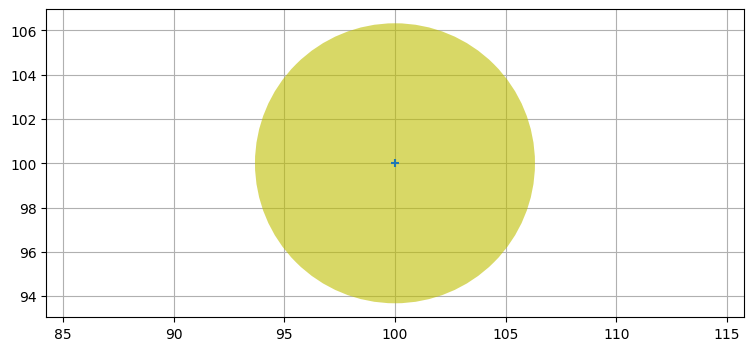

In [53]:
from kf_book.kf_design_internal import sensor_fusion_kf

kf = sensor_fusion_kf()
x0, p0 = kf.x.copy(), kf.P.copy()
plot_covariance_ellipse(x0, p0, fc='y', ec=None, alpha=0.6)

我们同样不确定 x 和 y 中的位置，因此协方差是循环的。

现在我们将使用来自第一个雷达的读数更新卡尔曼滤波器。 我将方位误差的标准差设置为 0.5$^\circ$，距离误差的标准差设置为 3。

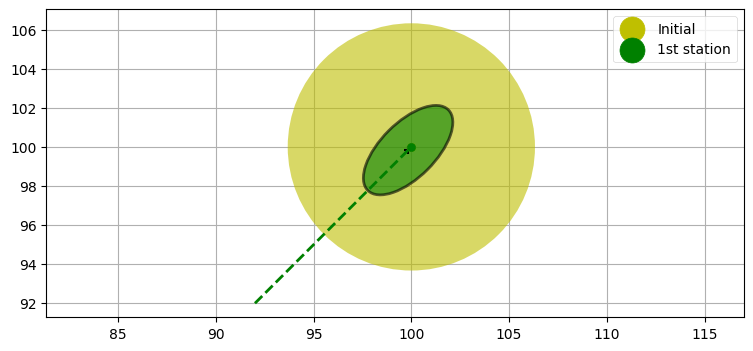

In [54]:
from math import radians
from kf_book.kf_design_internal import sensor_fusion_kf, set_radar_pos

# set the error of the radar's bearing and distance
kf.R[0, 0] = radians (.5)**2
kf.R[1, 1] = 3.**2

# compute position and covariance from first radar station
set_radar_pos((50, 50))
dist = (50**2 + 50**2) ** 0.5
kf.predict()
kf.update([radians(45), dist])

# plot the results
x1, p1 = kf.x.copy(), kf.P.copy()

plot_covariance_ellipse(x0, p0, fc='y', ec=None, alpha=0.6)
plot_covariance_ellipse(x1, p1, fc='g', ec='k', alpha=0.6)

plt.scatter([100], [100], c='y', label='Initial')
plt.scatter([100], [100], c='g', label='1st station')
plt.legend(scatterpoints=1, markerscale=3)
plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--');

我们可以看到错误对问题几何的影响。 雷达站位于目标的左下方。 方位测量在 $\sigma=0.5^\circ$ 时非常准确，但距离误差在 $\sigma=3$ 时不准确。 我用绿色虚线显示了雷达读数。 我们可以很容易地看到准确方位角和不准确距离对协方差椭圆形状的影响。

现在我们可以合并第二个雷达站的测量。 第二个雷达位于 (150,50)，位于目标的下方和右侧。 在你继续之前，想一想当我们合并这个新读数时，你认为协方差会如何变化。

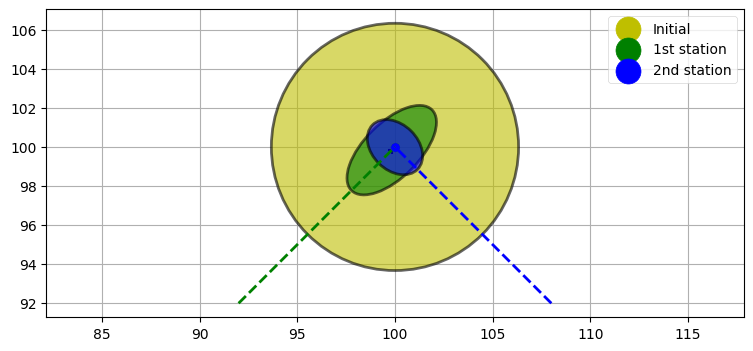

In [55]:
# compute position and covariance from second radar station
set_radar_pos((150, 50))
kf.predict()
kf.update([radians(135), dist])

plot_covariance_ellipse(x0, p0, fc='y', ec='k', alpha=0.6)
plot_covariance_ellipse(x1, p1, fc='g', ec='k', alpha=0.6)
plot_covariance_ellipse(kf.x, kf.P, fc='b', ec='k', alpha=0.6)

plt.scatter([100], [100], c='y', label='Initial')
plt.scatter([100], [100], c='g', label='1st station')
plt.scatter([100], [100], c='b', label='2nd station')
plt.legend(scatterpoints=1, markerscale=3)
plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
plt.plot([108, 100], [92, 100], c='b', lw=2, ls='--');

我们可以看到第二次雷达测量是如何改变协方差的。与目标的角度与第一个雷达站正交，因此方位和范围误差的影响被交换。所以协方差矩阵的角度切换到与第二站的方向匹配。需要注意的是，方向不仅发生了变化，而且还发生了变化。协方差矩阵的大小也变得更小。

协方差将始终包含所有可用信息，包括问题几何的影响。这种公式可以特别容易地查看正在发生的事情，但是如果一个传感器为您提供位置，而第二个传感器为您提供速度，或者如果两个传感器提供位置测量，则会发生同样的事情。

在我们继续之前的最后一件事：传感器融合是一个庞大的话题，我的报道过于简单化到了误导的地步。例如，GPS 使用迭代最小二乘法从一组来自卫星的伪距读数中确定位置，而不使用卡尔曼滤波器。我在支持笔记本 [**Iterative Least Squares for Sensor Fusion**](http://nbviewer.ipython.org/urls/raw.github.com/rlabbe/Kalman-and-Bayesian-Filters-in -Python/master/Supporting_Notebooks/Iterative-Least-Squares-for-Sensor-Fusion.ipynb)

这是在 GPS 接收器中完成此计算的常用方式，但并非唯一方式。如果您是业余爱好者，我的报道可能会让您入门。商业级过滤器需要非常仔细地设计融合过程。这是几本书的主题，您必须通过找到涵盖您的领域的一本来进一步学习。

### Exercise: Can you Filter GPS outputs?

在上面的部分中，我让您将卡尔曼滤波器应用于“类似 GPS”的传感器。 您可以将卡尔曼滤波器应用于商业卡尔曼滤波器的输出吗？ 换句话说，您的过滤器的输出会比 GPS 的输出好、差还是等于 GPS 的输出？

#### Solution

商业 GPS 内置了卡尔曼滤波器，它们的输出是由该滤波器创建的滤波估计值。因此，假设您有来自 GPS 的稳定输出流，其中包含位置和位置误差。您不能将这两条数据传递到您自己的过滤器中吗？

那么，该数据流的特征是什么，更重要的是，卡尔曼滤波器的输入的基本要求是什么？

卡尔曼滤波器的输入必须是*高斯*和*时间无关*。这是因为我们强加了马尔可夫属性的要求：当前状态仅依赖于先前状态和当前输入。这使得过滤器的递归形式成为可能。 GPS 的输出是*时间相关的*，因为滤波器的当前估计基于所有先前测量的递归估计。因此，信号不是白色的，它不是时间独立的，如果您将该数据传递到卡尔曼滤波器中，您就违反了滤波器的数学要求。因此，答案是否定的，您无法通过在商业 GPS 的输出上运行 KF 来获得更好的估计。

另一种思考方式是卡尔曼滤波器在最小二乘意义上是最优的。没有办法采取最佳解决方案，将其通过过滤器，任何过滤器，并获得“更优化”的答案，因为这在逻辑上是不可能的。充其量信号将保持不变，在这种情况下它仍然是最佳的，或者它会改变，因此不再是最佳的。

这是爱好者在尝试集成 GPS、IMU 和其他现成传感器时面临的难题。

我们来看看效果。商业 GPS 报告位置和估计的误差范围。估计误差仅来自卡尔曼滤波器的 $\mathbf P$ 矩阵。那么让我们过滤一些噪声数据，将过滤后的输出作为新的噪声输入到过滤器，看看结果如何。换句话说，$\mathbf x$ 将提供 $\mathbf z$ 输入，$\mathbf P$ 将提供测量协方差 $\mathbf R$。为了稍微夸大效果以使它们更明显，我将绘制执行此操作的效果，然后再绘制第二次。第二次迭代没有任何“意义”（没有人会尝试），它只是帮助我说明了一个观点。首先，代码和情节。

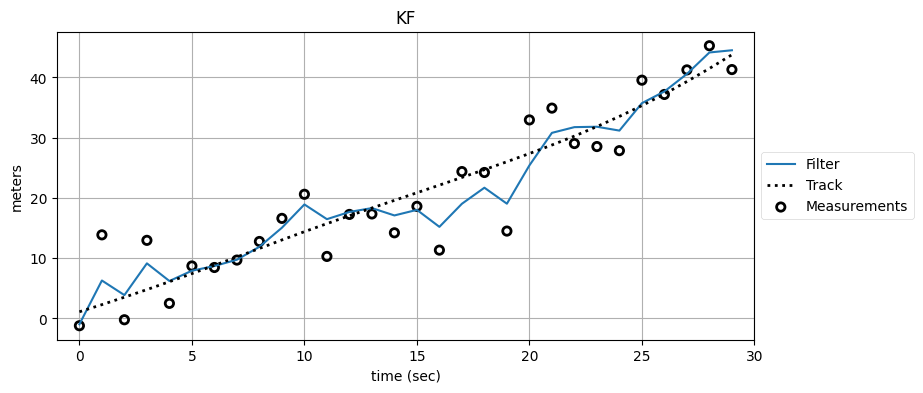

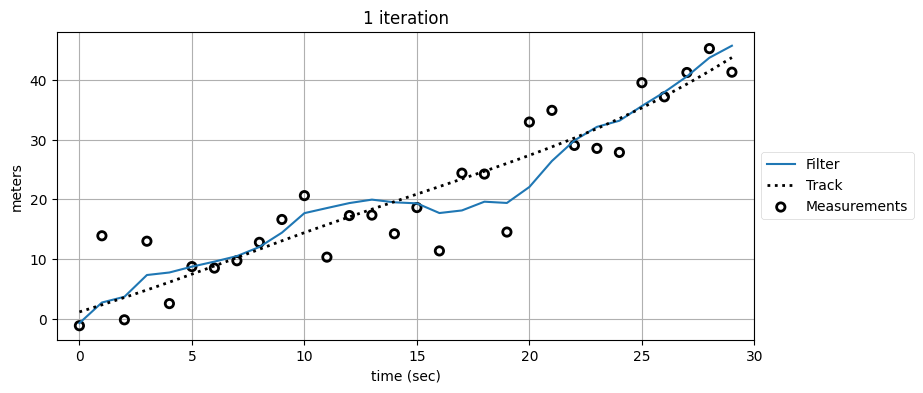

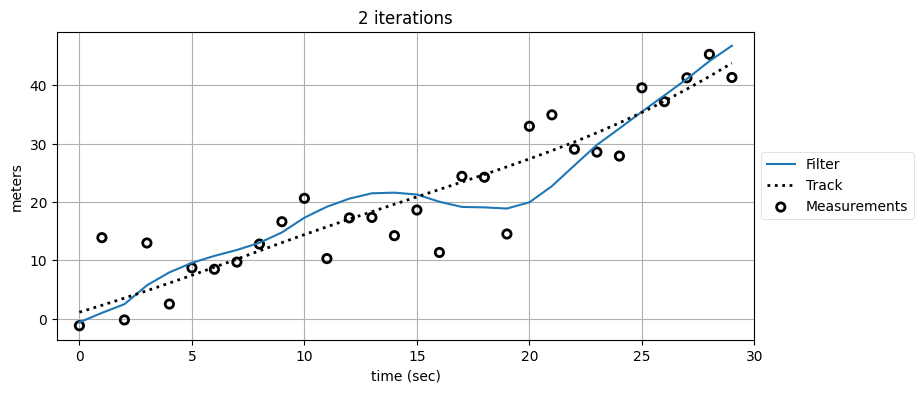

(5.0, 0.02)

In [56]:
np.random.seed(124)
R = 5.
xs, zs = simulate_acc_system(R=R, Q=Q, count=30)

kf0 = SecondOrderKF(R, Q, dt=1)
kf1 = SecondOrderKF(R, Q, dt=1)
kf2 = SecondOrderKF(R, Q, dt=1)

# Filter measurements
fxs0, ps0, _, _ = kf0.batch_filter(zs)

# filter twice more, using the state as the input
fxs1, ps1, _, _ = kf1.batch_filter(fxs0[:, 0])
fxs2, _, _, _ = kf2.batch_filter(fxs1[:, 0])

plot_kf_output(xs, fxs0, zs, 'KF', False)
plot_kf_output(xs, fxs1, zs, '1 iteration', False)
plot_kf_output(xs, fxs2, zs, '2 iterations', False)
R,Q

我们看到再处理信号的滤波输出更平滑，但它也偏离了轨道。怎么了？回想一下，卡尔曼滤波器要求信号不是时间相关的。然而，卡尔曼滤波器的输出 * 是 * 时间相关的，因为它将所有先前的测量值合并到它对该时间段的估计中。因此，请查看最后一张图，进行 2 次迭代。测量从几个比轨道大的峰值开始。这被过滤器“记住”（这是一个模糊的术语，但我试图避免数学），并且它已经开始计算对象在轨道上方。稍后，在大约 13 秒时，我们有一个时间段，测量值都恰好在轨道下方。这也被合并到过滤器的内存中，并且迭代输出远低于轨道。

现在让我们以不同的方式来看待这个问题。迭代输出*不是*使用 $\mathbf z$ 作为测量值，而是先前卡尔曼滤波器估计的输出。因此，我将根据前一个过滤器的输出绘制过滤器的输出。

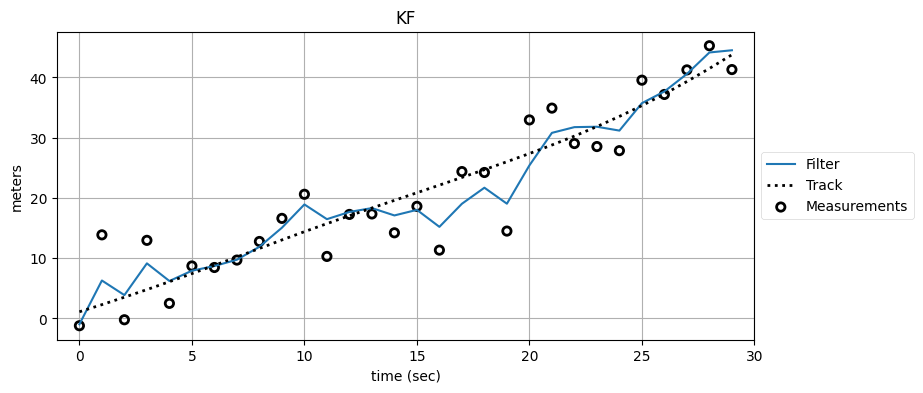

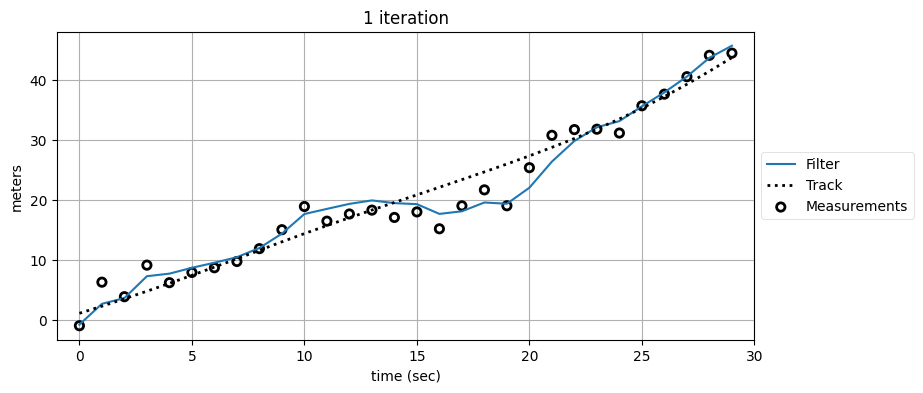

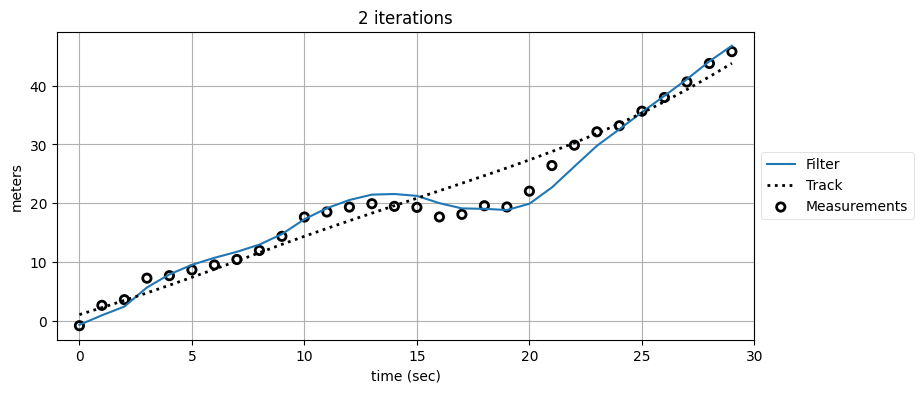

In [57]:
plot_kf_output(xs, fxs0, zs, title='KF', aspect_equal=False)
plot_kf_output(xs, fxs1, fxs0[:, 0], '1 iteration', False)
plot_kf_output(xs, fxs2, fxs1[:, 0], '2 iterations', False)

我希望这种方法的问题现在很明显。 在底部图表中，我们可以看到 KF 正在跟踪先前滤波器的不完美估计，并且由于先前测量值的记忆被合并到信号中，因此还将延迟合并到信号中。

### Exercise: Prove that the position sensor improves the filter

设计一种方法来证明融合位置传感器和车轮测量结果比单独使用车轮产生更好的结果。

#### Solution 1

通过将位置传感器的测量噪声设置为接近无限的值，强制卡尔曼滤波器忽略位置传感器测量。 重新运行过滤器并观察残差的标准偏差

In [58]:
fusion_test(1.5, 3.0, do_plot=False)
fusion_test(1.5, 1.e40, do_plot=False)

fusion std: 1.647
fusion std: 1.647


#### Solution 2

这是更多的工作，但我们可以编写一个只进行一次测量的卡尔曼滤波器。

std: 0.523


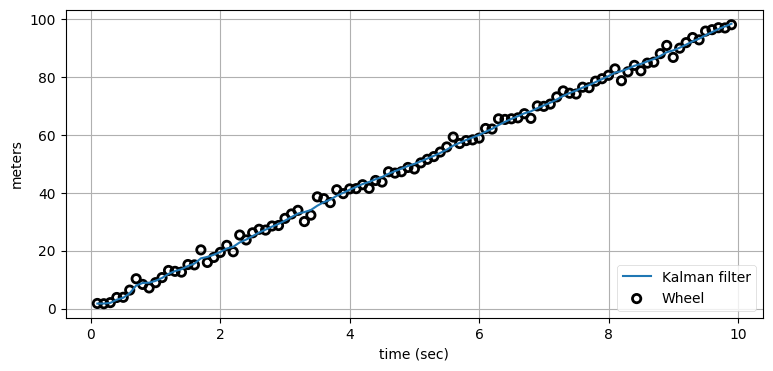

In [59]:
dt = 0.1
wheel_sigma = 1.5
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.F = array([[1., dt], [0., 1.]])
kf.H = array([[1., 0.]])
kf.x = array([[0.], [1.]])
kf.Q *= 0.01
kf.P *= 100
kf.R[0, 0] = wheel_sigma**2

random.seed(1123)
nom = range(1, 100)
zs = np.array([i + randn()*wheel_sigma for i in nom])
xs, _, _, _ = kf.batch_filter(zs)
ts = np.arange(0.1, 10, .1)

res = nom - xs[:, 0, 0]
print(f'std: {np.std(res):.3f}')

plot_filter(ts, xs[:, 0], label='Kalman filter')
plot_measurements(ts, zs, label='Wheel')
set_labels(x='time (sec)', y='meters')
plt.legend(loc=4);

在这次运行中，我得到了 0.523 的标准偏差，而融合测量的值为 0.391。

## Nonstationary Processes

到目前为止，我们假设卡尔曼滤波器中的各种矩阵是*平稳的* - 随着时间的推移不变。 例如，在机器人跟踪部分，我们假设 $\Delta t = 1.0$ 秒，并将状态转移矩阵设计为

$$
\mathbf F = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix} = \begin{bmatrix}1& 1& 0& 0\\0& 1& 0& 0\\0& 0& 1& 1\\ 0& 0& 0& 1\end{bmatrix}$$

但是，如果我们的数据速率以某种不可预测的方式发生变化怎么办？ 或者，如果我们有两个传感器，每个传感器都以不同的速率运行呢？ 如果测量误差发生变化怎么办？

处理这个很容易； 您只需更改卡尔曼滤波器矩阵以反映当前情况。 让我们回到我们的狗跟踪问题并假设数据输入是零星的。 针对这个问题我们设计了


$$\begin{aligned}
\mathbf{\bar x} &= {\begin{bmatrix}x\\\dot x\end{bmatrix}}^- \\
\mathbf F &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix} 
\end{aligned}$$

并在初始化期间设置卡尔曼滤波器变量“F”，如下所示：

```python
dt = 0.1
kf.F = np.array([[1, dt],
                 [0, 1]])
```

我们将如何处理每次测量的 $\Delta t$ 变化？ 这很容易 - 只需修改相关矩阵。 在这种情况下，`F` 是变体，所以我们需要在更新/预测循环中更新它。 `Q` 也取决于时间，因此也必须在每个循环期间分配。 这是我们如何编码的示例：

In [60]:
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = array([0., 1.])
kf.H = array([[1, 0]])
kf.P = np.eye(2) * 50
kf.R = np.eye(1)
q_var = 0.02

# measurement tuple: (value, time)
zs = [(1., 1.),  (2., 1.1), (3., 0.9), (4.1, 1.23), (5.01, 0.97)]
for z, dt in zs:
    kf.F = array([[1, dt],
                  [0, 1]])
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=q_var)
    kf.predict()
    kf.update(z)
    print(kf.x)

[1. 1.]
[2.   0.92]
[2.96 1.  ]
[4.12 0.97]
[5.03 0.96]


### Sensor fusion: Different Data Rates

两个不同的传感器类别以相同的速率输出数据的情况很少见。 假设位置传感器以 3 Hz 的频率产生更新，而车轮以 7 Hz 的频率更新。 进一步假设时间不精确 - 存在一点抖动，因此测量可能会在预测时间之前或之后发生。 让我通过让轮子提供速度估计而不是位置估计来使情况进一步复杂化。

我们可以通过等待来自任一传感器的数据包来做到这一点。 当我们得到它时，我们会确定自上次更新以来经过的时间量。 然后我们需要修改受影响的矩阵。 $\mathbf F$ 和 $\mathbf Q$ 都包含一个时间项 $\Delta t$，因此我们需要在每次创新时调整它们。

每次测量都会改变，所以我们必须修改 $\mathbf H$ 和 $\mathbf R$。 位置传感器改变 $\mathbf x$ 的位置元素，因此我们指定：

$$\begin{aligned}
\mathbf H &= \begin{bmatrix}1 &0\end{bmatrix} \\
\mathbf R &= \sigma_{ps}^2
\end{aligned}$$

车轮传感器改变了 $\mathbf x$ 的速度元素，因此我们指定：

$$\begin{aligned}
\mathbf H &= \begin{bmatrix}0 &1\end{bmatrix} \\
\mathbf R &= \sigma_{wheel}^2
\end{aligned}$$

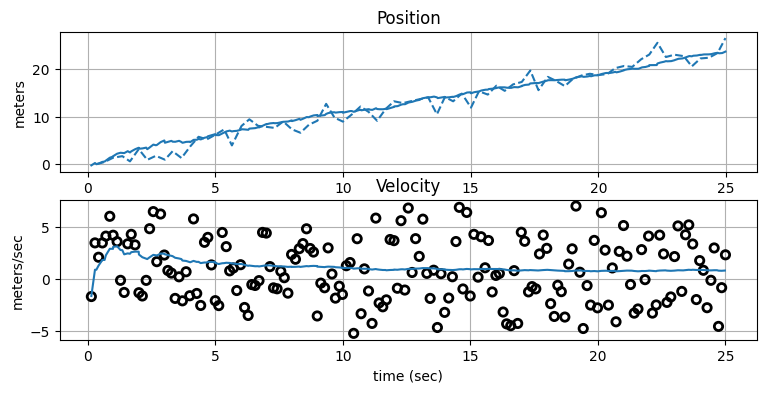

In [61]:
def gen_sensor_data(t, ps_std, wheel_std):
    # generate simulated sensor data
    pos_data, vel_data = [], []
    dt = 0.
    for i in range(t*3):
        dt += 1/3.
        t_i = dt + randn() * .01 # time jitter
        pos_data.append([t_i, t_i + randn()*ps_std])

    dt = 0.    
    for i in range(t*7):
        dt += 1/7.
        t_i = dt + randn() * .006 # time jitter
        vel_data.append([t_i, 1. + randn()*wheel_std])
    return pos_data, vel_data


def plot_fusion(xs, ts, zs_ps, zs_wheel):
    xs = np.array(xs)
    plt.subplot(211)
    plt.plot(zs_ps[:, 0], zs_ps[:, 1], ls='--', label='Pos Sensor')
    plot_filter(xs=ts, ys=xs[:, 0], label='Kalman filter')
    set_labels(title='Position', y='meters',)

    plt.subplot(212)
    plot_measurements(zs_wheel[:, 0], zs_wheel[:, 1],  label='Wheel')
    plot_filter(xs=ts, ys=xs[:, 1], label='Kalman filter')
    set_labels('Velocity', 'time (sec)', 'meters/sec')
    

def fusion_test(pos_data, vel_data, wheel_std, ps_std):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.F = array([[1., 1.], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.P *= 100

    xs, ts = [],  []
    
    # copy data for plotting
    zs_wheel = np.array(vel_data)
    zs_ps = np.array(pos_data)
                     
    last_t = 0
    while len(pos_data) > 0 and len(vel_data) > 0:
        if pos_data[0][0] < vel_data[0][0]:
            t, z = pos_data.pop(0)
            dt = t - last_t
            last_t = t
            
            kf.H = np.array([[1., 0.]])
            kf.R[0,0] = ps_std**2
        else:
            t, z = vel_data.pop(0)
            dt = t - last_t
            last_t = t
            
            kf.H = np.array([[0., 1.]])
            kf.R[0,0] = wheel_std**2

        kf.F[0,1] = dt
        kf.Q = Q_discrete_white_noise(2, dt=dt, var=.02)
        kf.predict()
        kf.update(np.array([z]))

        xs.append(kf.x.T[0])
        ts.append(t)
    plot_fusion(xs, ts, zs_ps, zs_wheel)

random.seed(1123)
pos_data, vel_data = gen_sensor_data(25, 1.5, 3.0)
fusion_test(pos_data, vel_data, 1.5, 3.0);

## Tracking a Ball

现在让我们将注意力转向我们正在跟踪的对象的物理受到约束的情况。 在真空中抛出的球必须遵守牛顿定律。 在恒定的引力场中，它将以抛物线运动。 我假设您熟悉公式的推导：

$$
\begin{aligned}
y &= \frac{g}{2}t^2 + v_{y0} t + y_0 \\
x &= v_{x0} t + x_0
\end{aligned}
$$

其中 $g$ 是引力常数，$t$ 是时间，$v_{x0}$ 和 $v_{y0}$ 是 x 和 y 平面的初始速度。 如果球以 $v$ 的初始速度在地平线以上的角度 $\theta$ 被抛出，我们可以计算 $v_{x0}$ 和 $v_{y0}$ 为

$$
\begin{aligned}
v_{x0} = v \cos{\theta} \\
v_{y0} = v \sin{\theta}
\end{aligned}
$$

因为我们没有真实的数据，我们将从编写一个球的模拟器开始。 与往常一样，我们添加了一个与时间无关的噪声项，因此我们可以模拟噪声传感器。

In [62]:
from math import radians, sin, cos
import math

def rk4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply to 
      compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

def fx(x,t):
    return fx.vel
    
def fy(y,t):
    return fy.vel - 9.8*t


class BallTrajectory2D(object):
    def __init__(self, x0, y0, velocity, 
                 theta_deg=0., 
                 g=9.8, 
                 noise=[0.0, 0.0]):
        self.x = x0
        self.y = y0
        self.t = 0        
        theta = math.radians(theta_deg)
        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity        
        self.g = g
        self.noise = noise
        
        
    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt 
        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])

因此，要创建从 (0, 15) 开始、速度为 100 m/s、角度为 60° 的轨迹，我们将编写：

```python
traj = BallTrajectory2D(x0=0, y0=15, velocity=100, theta_deg=60)
```
    
然后为每个时间步调用`traj.step(t)`。 让我们测试一下

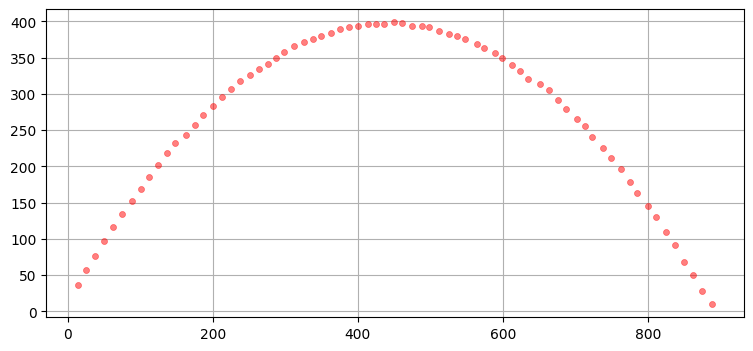

In [63]:
def test_ball_vacuum(noise):
    y = 15
    x = 0
    ball = BallTrajectory2D(x0=x, y0=y, 
                            theta_deg=60., velocity=100., 
                            noise=noise)
    t = 0
    dt = 0.25
    while y >= 0:
        x, y = ball.step(dt)
        t += dt
        if y >= 0:
            plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)
         
    plt.axis('equal');
    
#test_ball_vacuum([0, 0]) # plot ideal ball position
test_ball_vacuum([1, 1]) # plot with noise 

这看起来很合理，所以让我们继续（为读者练习：更稳健地验证此模拟）。

### Choose the State Variables

我们可能会考虑使用与跟踪狗相同的状态变量。 但是，这行不通。 回想一下，卡尔曼滤波器状态转换必须写为 $\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$，这意味着我们必须从前一个状态计算当前状态。 我们的假设是球在真空中运动，因此 x 中的速度是一个常数，而 y 中的加速度完全取决于引力常数 $g$。 我们可以使用众所周知的欧拉方法对牛顿方程进行离散化，其中 $\Delta t$ 为：

$$\begin{aligned}
x_t &=  x_{t-1} + v_{x(t-1)} {\Delta t} \\
v_{xt} &= v_{x(t-1)} \\
y_t &= y_{t-1} + v_{y(t-1)} {\Delta t} \\
v_{yt} &= -g {\Delta t} + v_{y(t-1)} \\
\end{aligned}
$$

> **侧边栏**：*欧拉方法通过假设斜率（导数）在时间 $t$ 处为常数来逐步积分微分方程。 在这种情况下，位置的导数是速度。 在每个时间步 $\Delta t$ 我们假设一个恒定的速度，计算新的位置，然后更新下一个时间步的速度。 有更准确的方法，例如我们可用的龙格库塔，但因为我们在每一步中都使用测量值更新状态，所以欧拉方法非常准确。 如果您需要使用 Runge-Kutta，您必须编写自己的 `predict()` 函数来计算 $\mathbf x$ 的状态转换，然后使用正常的卡尔曼滤波器方程 $\mathbf{\bar P}= \mathbf{FPF}^\mathsf T + \mathbf Q$ 更新协方差矩阵。*
This implies that we need to incorporate acceleration for $y$ into the Kalman filter, but not for $x$. This suggests the following state variable.

$$
\mathbf x = 
\begin{bmatrix}
x & \dot x & y & \dot y & \ddot{y}
\end{bmatrix}^\mathsf T
$$

然而，加速度是由于重力，这是一个常数。与其要求卡尔曼滤波器跟踪一个常数，我们可以将重力视为它的本质——一个控制输入。换句话说，重力是一种以已知方式改变系统行为的力，它会在球的整个飞行过程中施加。

状态预测的方程是 $\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$。 $\mathbf{Fx}$ 是我们将用来模拟球的位置和速度的熟悉的状态转换函数。向量 $\mathbf{u}$ 让您可以指定过滤器的控制输入。对于汽车来说，控制输入将是诸如油门和制动器的踩下量、方向盘的位置等。对于我们的球，控制输入将是重力。矩阵 $\mathbf{B}$ 模拟控制输入如何影响系统的行为。同样，对于汽车，$\mathbf{B}$ 会将刹车和加速器的输入转换为速度变化，并将方向盘的输入转换为不同的位置和航向。对于我们的球跟踪问题，它将计算由于重力引起的速度变化。我们将很快详细介绍。现在，我们将状态变量设计为

$$
\mathbf x = 
\begin{bmatrix}x & \dot x & y & \dot y 
\end{bmatrix}^\mathsf T
$$

### Design State Transition Function

我们的下一步是设计状态转换函数。 回想一下，状态转换函数是作为矩阵 $\mathbf F$ 实现的，我们将它与系统的前一个状态相乘以获得下一个状态，或先验 $\bar{\mathbf x} = \mathbf{Fx}$。

我不会对此进行详细说明，因为它与我们在前一章中所做的一维案例非常相似。 我们的位置和速度状态方程为：

$$
\begin{aligned}
\bar x &= (1*x) + (\Delta t * v_x) + (0*y) + (0 * v_y) \\
\bar v_x &= (0*x) +  (1*v_x) + (0*y) + (0 * v_y) \\
\bar y &= (0*x) + (0* v_x)         + (1*y) + (\Delta t * v_y)   \\
\bar v_y &= (0*x) +  (0*v_x) + (0*y) + (1*v_y) 
\end{aligned}
$$

请注意，没有一个术语包括 $g$，即引力常数。 正如我在上一个函数中解释的那样，我们将使用卡尔曼滤波器的控制输入来解释重力。
在矩阵形式中，我们将其写为：

$$
\mathbf F = \begin{bmatrix}
1 & \Delta t & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

### Design the Control Input Function

我们将使用控制输入来解释重力。 术语 $\mathbf{Bu}$ 被添加到 $\mathbf{\bar x}$ 以说明 $\mathbf{\bar x}$ 因重力而发生的变化。 我们可以说 $\mathbf{Bu}$ 包含 $\begin{bmatrix}\Delta x_g & \Delta \dot{x_g} & \Delta y_g & \Delta \dot{y_g}\end{bmatrix}^\mathsf T 美元。

如果我们查看离散方程，我们会发现重力只影响 $y$ 的速度。

$$\begin{aligned}
x_t &=  x_{t-1} + v_{x(t-1)} {\Delta t} \\
v_{xt} &= vx_{t-1}
\\
y_t &= y_{t-1} + v_{y(t-1)} {\Delta t}\\
v_{yt} &= -g {\Delta t} + v_{y(t-1)} \\
\end{aligned}
$$

因此我们希望积 $\mathbf{Bu}$ 等于 $\begin{bmatrix}0 & 0 & 0 & -g \Delta t \end{bmatrix}^\mathsf T$。 从某种意义上说，我们如何定义 $\mathbf{B}$ 和 $\mathbf{u}$ 是任意的，只要将它们相乘产生这个结果。 例如，我们可以定义 $\mathbf{B}=1$ 和 $\mathbf{u} = \begin{bmatrix}0 & 0 & 0 & -g \Delta t \end{bmatrix}^\mathsf T$。 但这并不真正符合我们对 $\mathbf{B}$ 和 $\mathbf{u}$ 的定义，其中 $\mathbf{u}$ 是控制输入，$\mathbf{B}$ 是 控制功能。 对于 y 的速度，控制输入是 $-g$。 所以这是一种可能的定义。

$$\mathbf{B} = \begin{bmatrix}0&0&0&0 \\ 0&0&0&0 \\0&0&0&0 \\0&0&0&\Delta t\end{bmatrix}, \mathbf{u} = \begin{bmatrix}0\\0\\0\\-g\end{bmatrix}$$

对我来说，这似乎有点过分了。 我建议我们可能希望 $\mathbf{u}$ 包含 $x$ 和 $y$ 两个维度的控制输入，这表明

$$\mathbf{B} = \begin{bmatrix}0&0 \\ 0&0 \\0&0 \\0&\Delta t\end{bmatrix}, \mathbf{u} = \begin{bmatrix}0\\-g\end{bmatrix}$$.

您可能更愿意只提供实际存在的控制输入，并且 $x$ 没有控制输入，所以我们得出

$$\mathbf{B} = \begin{bmatrix}0 \\ 0 \\0\\ \Delta t\end{bmatrix}, \mathbf{u} = \begin{bmatrix}-g\end{bmatrix}$$.

我见过人们使用

$$\mathbf{B} = \begin{bmatrix}0&0&0&0 \\ 0&0&0&0 \\0&0&0&0 \\0&0&0&1\end{bmatrix}, \mathbf{u} = \begin{bmatrix}0\\0\\0\\-g \Delta t\end{bmatrix}$$

虽然这确实产生了正确的结果，但我拒绝将时间放入 $\mathbf{u}$，因为时间不是控制输入，它是我们用来将控制输入转换为状态变化的东西，这就是工作 $\mathbf{B}$。

### Design the Measurement Function

测量函数使用方程 $\mathbf z = \mathbf{Hx}$ 定义了我们如何从状态变量到测量值。 我们假设我们有一个传感器，可以为我们提供球在 (x,y) 中的位置，但不能测量速度或加速度。 因此我们的函数必须是：

$$
\begin{bmatrix}z_x \\ z_y \end{bmatrix}= 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix} 
\begin{bmatrix}
x \\
\dot x \\
y \\
\dot y \end{bmatrix}$$

where

$$\mathbf H = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix}$$

### Design the Measurement Noise Matrix

与机器人一样，我们假设误差在 $x$ 和 $y$ 中是独立的。 在这种情况下，我们首先假设 x 和 y 的测量误差为 0.5 平方米。 因此，

$$\mathbf R = \begin{bmatrix}0.5&0\\0&0.5\end{bmatrix}$$

### Design the Process Noise Matrix

我们假设一个球在真空中移动，所以应该没有过程噪音。 我们有 4 个状态变量，所以我们需要一个 $4{\times}4$ 协方差矩阵：

$$\mathbf Q = \begin{bmatrix}0&0&0&0\\0&0&0&0\\0&0&0&0\\0&0&0&0\end{bmatrix}$$

### Design the Initial Conditions

我们在测试状态转换函数时已经执行了这一步。 回想一下，我们使用三角函数计算了 $x$ 和 $y$ 的初始速度，并将 $\mathbf x$ 的值设置为：

```python
omega = radians(omega)
vx = cos(omega) * v0
vy = sin(omega) * v0

f1.x = np.array([[x, vx, y, vy]]).T
```
    
完成所有步骤后，我们就可以实现过滤器并对其进行测试了。 一、实现：

In [64]:
from math import sin, cos, radians

def ball_kf(x, y, omega, v0, dt, r=0.5, q=0.):
    kf = KalmanFilter(dim_x=4, dim_z=2, dim_u=1)

    kf.F = np.array([[1., dt, 0., 0.],   # x   = x0 + dx*dt
                     [0., 1., 0., 0.],   # dx  = dx0
                     [0., 0., 1., dt],   # y   = y0 + dy*dt
                     [0., 0., 0., 1.]])  # dy  = dy0

    kf.H = np.array([[1., 0., 0., 0.],
                     [0., 0., 1., 0.]])
    
    kf.B = np.array([[0., 0., 0., dt]]).T
    kf.R *= r
    kf.Q *= q

    omega = radians(omega)
    vx = cos(omega) * v0
    vy = sin(omega) * v0
    kf.x = np.array([[x, vx, y, vy]]).T
    return kf

现在我们将通过使用球模拟类生成球的测量值来测试过滤器。

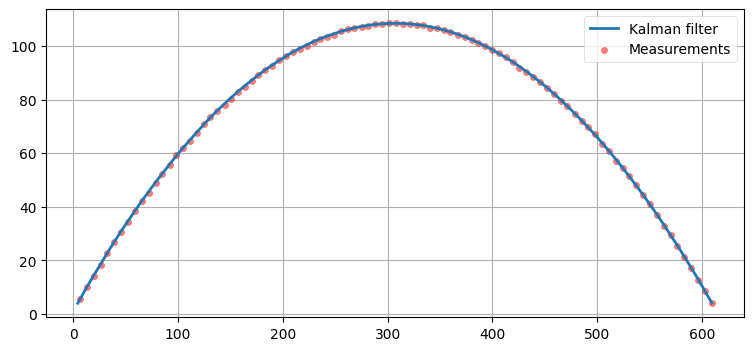

In [65]:
def track_ball_vacuum(dt):
    global kf
    x, y = 0., 1.
    theta = 35.  # launch angle
    v0 = 80.
    g = np.array([[-9.8]])  # gravitational constant
    ball = BallTrajectory2D(x0=x, y0=y, theta_deg=theta, velocity=v0, 
                            noise=[.2, .2])
    kf = ball_kf(x, y, theta, v0, dt)

    t = 0
    xs, ys = [], []
    while kf.x[2] > 0:
        t += dt
        x, y = ball.step(dt)
        z = np.array([[x, y]]).T

        kf.update(z)
        xs.append(kf.x[0])
        ys.append(kf.x[2])    
        kf.predict(u=g)     
        p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)
    p2, = plt.plot(xs, ys, lw=2)
    plt.legend([p2, p1], ['Kalman filter', 'Measurements'],
               scatterpoints=1)
    
track_ball_vacuum(dt=1./10)

我们看到卡尔曼滤波器合理地跟踪球。 然而，正如已经解释过的，这是一个微不足道的例子，因为我们没有过程噪声。 我们可以以任意精度预测真空中的轨迹； 在这个例子中使用卡尔曼滤波器是不必要的复杂化。 最小二乘曲线拟合将给出相同的结果。

## Tracking a Ball in Air

对于这个问题，我们假设我们正在跟踪一个穿过地球大气层的球。球的路径受风、阻力和球旋转的影响。我们将假设我们的传感器是相机；我们不会实现的代码将执行某种类型的图像处理来检测球的位置。这在计算机视觉中通常称为 *blob detection*。但是，图像处理代码并不完美；在任何给定的帧中，既可以检测到没有斑点，也可以检测到与球不对应的虚假斑点。最后，我们不会假设我们知道球的起始位置、角度或旋转；跟踪代码必须根据提供的测量值启动跟踪。我们在这里所做的主要简化是 2D 世界；我们假设球总是垂直于相机传感器的平面运动。在这一点上我们必须进行简化，因为我们还没有讨论如何从仅提供 2D 数据的相机中提取 3D 信息。

### Implementing Air Drag

我们的第一步是实现一个球在空气中移动的数学。有几种治疗方法可供选择。一个稳健的解决方案会考虑诸如球粗糙度（它会根据速度非线性地影响阻力）、马格努斯效应（旋转导致球的一侧相对于空气相对于另一侧具有更高的速度，因此系数阻力在相对侧不同），升力，湿度，空气密度等的影响。我假设读者对球物理的细节不感兴趣，因此将这种处理限制为空气阻力对非旋转棒球的影响。我将使用 Nicholas Giordano 和 Hisao Nakanishi 在 *Computational Physics* [1997] 中开发的数学。这种处理没有考虑所有因素。 Alan Nathan 在他的网站 http://baseball.physics.illinois.edu/index.html 上进行了最详细的处理。我在自己的计算机视觉工作中使用了他的数学，但我不想被更复杂的模型分散注意力。

**重要**：在我继续之前，让我指出，您无需了解下一部分物理知识即可继续使用卡尔曼滤波器。我的目标是在现实世界中创建一个相当准确的棒球行为，以便我们可以测试我们的卡尔曼滤波器在现实世界行为中的表现。在现实世界的应用程序中，通常不可能对现实世界系统的物理特性进行完全建模，我们使用包含大规模行为的过程模型来凑合。然后我们调整测量噪声和过程噪声，直到滤波器与我们的数据配合良好。这确实存在风险；微调卡尔曼滤波器很容易，因此它可以完美地处理您的测试数据，但在呈现略有不同的数据时表现不佳。这可能是设计卡尔曼滤波器最困难的部分，也是为什么它被称为“黑艺术”之类的术语。

我不喜欢没有解释就实现事物的书籍，所以我现在将开发一个球在空气中移动的物理学。 如果您不感兴趣，请继续执行模拟。

在空气中移动的球会遇到风阻。 这会在墙上施加一个称为 *drag* 的力，它会改变球的飞行。 在佐丹奴这被表示为

$$F_{drag} = -B_2v^2$$

其中$B_2$ 是实验得出的系数，$v$ 是物体的速度。 $F_{drag}$ 可以分解为 $x$ 和 $y$ 组件

$$\begin{aligned}
F_{drag,x} &= -B_2v v_x\\
F_{drag,y} &= -B_2v v_y
\end{aligned}$$

如果 $m$ 是球的质量，我们可以使用 $F=ma$ 来计算加速度为

$$\begin{aligned} 
a_x &= -\frac{B_2}{m}v v_x\\
a_y &= -\frac{B_2}{m}v v_y
\end{aligned}$$

Giordano 为 $\frac{B_2}{m}$ 提供了以下函数，其中考虑了空气密度、棒球的横截面和粗糙度。 了解这是基于风洞测试和几个简化假设的近似值。 它采用 SI 单位：速度以米/秒为单位，时间以秒为单位。

$$\frac{B_2}{m} = 0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}}$$

从真空中球路径的 Euler 离散化开始：

$$\begin{aligned}
x &= v_x \Delta t \\
y &= v_y \Delta t \\
v_x &= v_x \\
v_y &= v_y - 9.8 \Delta t
\end{aligned}
$$

我们可以通过将 $accel * \Delta t$ 合并到速度更新方程中来将这个力（加速度）合并到我们的方程中。我们应该减去这个分量，因为阻力会降低速度。执行此操作的代码非常简单，我们只需要将力分解为 $x$ 和 $y$ 组件。

我不会进一步阐述这个问题，因为计算物理学超出了本书的范围。认识到更高保真度的模拟需要结合高度、温度、球旋转和其他几个因素。如果您有兴趣，上述 Alan Nathan 的工作将涵盖这一点。我的目的是在我们的模拟中加入一些真实世界的行为，以测试卡尔曼滤波器使用的更简单的预测模型如何对这种行为做出反应。你的过程模型永远不会准确地模拟世界上发生的事情，设计一个好的卡尔曼滤波器的一个重要因素是仔细测试它在现实世界数据中的表现。

下面的代码计算了棒球在空中、海平面、有风时的行为。我在没有风的情况下绘制了相同的初始打击，然后以 10 英里/小时的速度顺风。棒球统计数据普遍以美国单位进行，我们将在此处效仿 (http://en.wikipedia.org/wiki/United_States_customary_units)。请注意，110 mph 的速度是棒球击出本垒打时的典型退出速度。

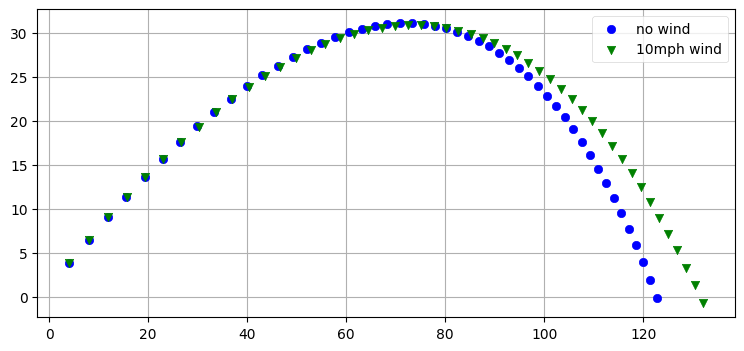

In [66]:
from math import sqrt, exp

def mph_to_mps(x):
    return x * .447

def drag_force(velocity):
    """ Returns the force on a baseball due to air drag at
    the specified velocity. Units are SI"""

    return velocity * (0.0039 + 0.0058 / 
            (1. + exp((velocity-35.)/5.)))

v = mph_to_mps(110.)
x, y = 0., 1.
dt = .1
theta = radians(35)

def solve(x, y, vel, v_wind, launch_angle):
    xs = []
    ys = []
    v_x = vel*cos(launch_angle)
    v_y = vel*sin(launch_angle)
    while y >= 0:
        # Euler equations for x and y
        x += v_x*dt
        y += v_y*dt

        # force due to air drag    
        velocity = sqrt((v_x-v_wind)**2 + v_y**2)    
        F = drag_force(velocity)

        # euler's equations for vx and vy
        v_x = v_x - F*(v_x-v_wind)*dt
        v_y = v_y - 9.8*dt - F*v_y*dt
        
        xs.append(x)
        ys.append(y)
    
    return xs, ys
        
x, y = solve(x=0, y=1, vel=v, v_wind=0, launch_angle=theta)
p1 = plt.scatter(x, y, color='blue', label='no wind')

wind = mph_to_mps(10)
x, y = solve(x=0, y=1, vel=v, v_wind=wind, launch_angle=theta)
p2 = plt.scatter(x, y, color='green', marker="v", 
                 label='10mph wind')
plt.legend(scatterpoints=1);

我们可以很容易地看到真空和空气中的轨迹之间的差异。在上面的真空部分，我在球中使用了相同的初始速度和发射角度。我们计算出真空中的球将行进超过 240 米（近 800 英尺）。在空中，距离刚刚超过 120 米，或大约 400 英尺。400 英尺对于击打好的本垒打球来说是一个真实的距离，因此我们可以确信我们的模拟相当准确。

事不宜迟，我们将创建一个球模拟，使用上面的数学来创建更真实的球轨迹。我会注意到阻力的非线性行为意味着在任何时间点都没有球位置的解析解，因此我们需要逐步计算位置。我使用欧拉的方法来传播解决方案；使用更准确的技术（如 Runge-Kutta）留给读者作为练习。对于我们正在做的事情来说，这种适度的复杂性是不必要的，因为对于我们将使用的时间步长而言，技术之间的准确性差异将很小。

In [67]:
class BaseballPath:
    def __init__(self, x0, y0, launch_angle_deg, velocity_ms, 
                 noise=(1.0, 1.0)): 
        """ Create 2D baseball path object  
           (x = distance from start point in ground plane, 
            y=height above ground)
        
        x0,y0            initial position
        launch_angle_deg angle ball is travelling respective to 
                         ground plane
        velocity_ms      speeed of ball in meters/second
        noise            amount of noise to add to each position
                         in (x, y)
        """
        
        omega = radians(launch_angle_deg)
        self.v_x = velocity_ms * cos(omega)
        self.v_y = velocity_ms * sin(omega)

        self.x = x0
        self.y = y0
        self.noise = noise


    def drag_force(self, velocity):
        """ Returns the force on a baseball due to air drag at
        the specified velocity. Units are SI
        """
        B_m = 0.0039 + 0.0058 / (1. + exp((velocity-35.)/5.))
        return B_m * velocity


    def update(self, dt, vel_wind=0.):
        """ compute the ball position based on the specified time 
        step and wind velocity. Returns (x, y) position tuple.
        """

        # Euler equations for x and y
        self.x += self.v_x*dt
        self.y += self.v_y*dt

        # force due to air drag
        v_x_wind = self.v_x - vel_wind
        v = sqrt(v_x_wind**2 + self.v_y**2)
        F = self.drag_force(v)

        # Euler's equations for velocity
        self.v_x = self.v_x - F*v_x_wind*dt
        self.v_y = self.v_y - 9.81*dt - F*self.v_y*dt

        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])

现在我们可以根据这个模型创建的测量值来测试卡尔曼滤波器。

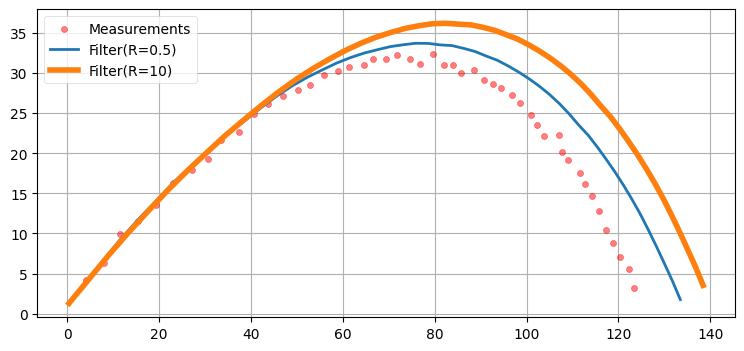

In [68]:
x, y = 0, 1.

theta = 35. # launch angle
v0 = 50.
dt = 1/10.   # time step
g = np.array([[-9.8]])

plt.figure()
ball = BaseballPath(x0=x, y0=y, launch_angle_deg=theta,
                    velocity_ms=v0, noise=[.3,.3])
f1 = ball_kf(x, y, theta, v0, dt, r=1.)
f2 = ball_kf(x, y, theta, v0, dt, r=10.)
t = 0
xs, ys = [], []
xs2, ys2 = [], []

while f1.x[2] > 0:
    t += dt
    x, y = ball.update(dt)
    z = np.array([[x, y]]).T

    f1.update(z)
    f2.update(z)
    xs.append(f1.x[0])
    ys.append(f1.x[2])
    xs2.append(f2.x[0])
    ys2.append(f2.x[2])    
    f1.predict(u=g) 
    f2.predict(u=g)
    
    p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)

p2, = plt.plot(xs, ys, lw=2)
p3, = plt.plot(xs2, ys2, lw=4)
plt.legend([p1, p2, p3], 
           ['Measurements', 'Filter(R=0.5)', 'Filter(R=10)'],
           loc='best', scatterpoints=1);

我绘制了两种不同卡尔曼滤波器设置的输出。测量值用绿色圆圈表示，R=0.5 的卡尔曼滤波器用绿色细线表示，R=10 的卡尔曼滤波器用蓝色粗线表示。选择这些 R 值只是为了显示测量噪声对输出的影响，并不意味着设计正确。

我们可以看到两个过滤器都做得很好。起初，两者都很好地跟踪了测量结果，但随着时间的推移，它们都出现了分歧。这是因为空气阻力的状态模型是非线性的，而卡尔曼滤波器假设它是线性的。如果您还记得我们在 g-h 滤波器一章中关于非线性的讨论，我们将说明为什么 g-h 滤波器总是落后于系统的加速度。我们在这里看到同样的事情——加速度是负的，所以卡尔曼滤波器总是超过球的位置。只要继续加速，过滤器就没有办法赶上，所以过滤器将继续发散。

我们可以做些什么来改善这一点？最好的方法是使用非线性卡尔曼滤波器进行滤波，我们将在后续章节中这样做。然而，对于这个问题，我也将称之为“工程”解决方案。我们的卡尔曼滤波器假设球在真空中，因此没有过程噪声。然而，由于球在空气中，因此大气会对球施加力。我们可以将这种力视为过程噪声。这不是一个特别严谨的想法；一方面，这种力绝不是高斯的。其次，我们可以计算这个力，所以举起手说“它是随机的”不会导致最优解。但是，让我们看看如果我们遵循这种思路会发生什么。

以下代码实现了与之前相同的卡尔曼滤波器，但过程噪声非零。我绘制了两个示例，一个使用“Q=.1”，一个使用“Q=0.01”。

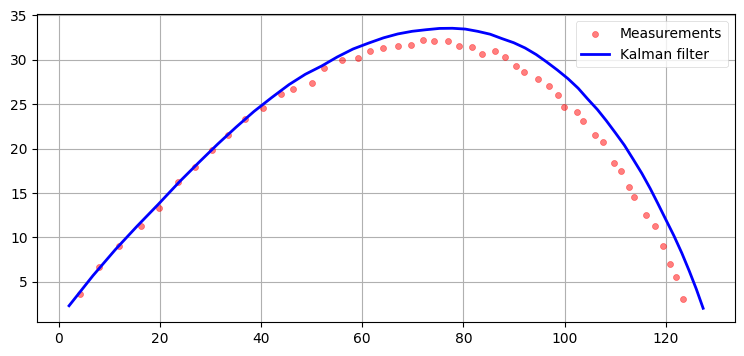

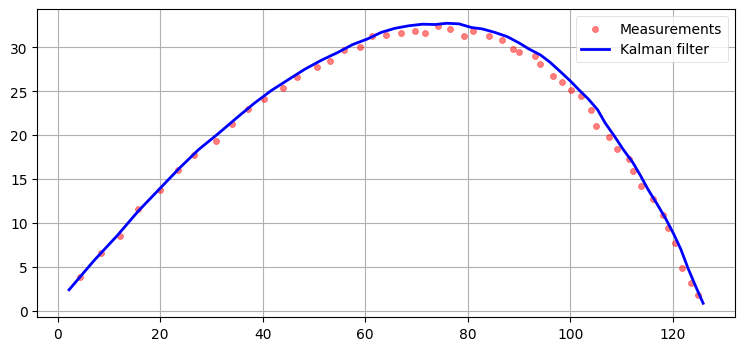

In [69]:
def plot_ball_with_q(q, r=1., noise=0.3):
    x, y = 0., 1.
    theta = 35. # launch angle
    v0 = 50.
    dt = 1/10.   # time step
    g = np.array([[-9.8]])

    ball = BaseballPath(x0=x, 
                        y0=y, 
                        launch_angle_deg=theta, 
                        velocity_ms=v0, 
                        noise=[noise,noise])
    f1 = ball_kf(x, y, theta, v0, dt, r=r, q=q)
    t = 0
    xs, ys = [], []

    while f1.x[2] > 0:
        t += dt
        x, y = ball.update(dt)
        z = np.array([[x, y]]).T

        f1.update(z)
        xs.append(f1.x[0])
        ys.append(f1.x[2]) 
        f1.predict(u=g) 

        p1 = plt.scatter(x, y, c='r', marker='.', s=75, alpha=0.5)

    p2, = plt.plot(xs, ys, lw=2, color='b')
    plt.legend([p1, p2], ['Measurements', 'Kalman filter'])
    plt.show()

plot_ball_with_q(0.01)
plot_ball_with_q(0.1)

第二个过滤器可以很好地跟踪测量结果。 似乎有一点滞后，但很少。

这是一个很好的技术吗？ 通常不会，但这取决于。 在这里，球上的力的非线性是相当恒定和有规律的。 假设我们正在尝试跟踪汽车——加速度会随着汽车速度和转弯的变化而变化。 当我们使过程噪声高于系统中的实际噪声时，滤波器将选择更高的测量权重。 如果您的测量中没有很多噪音，这可能对您有用。 但是，请考虑下一个图，其中我增加了测量中的噪声。

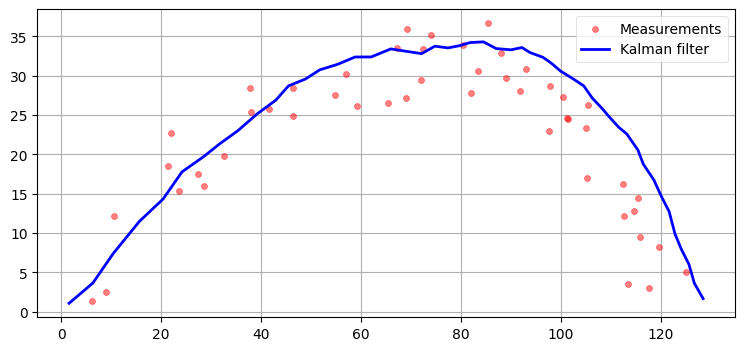

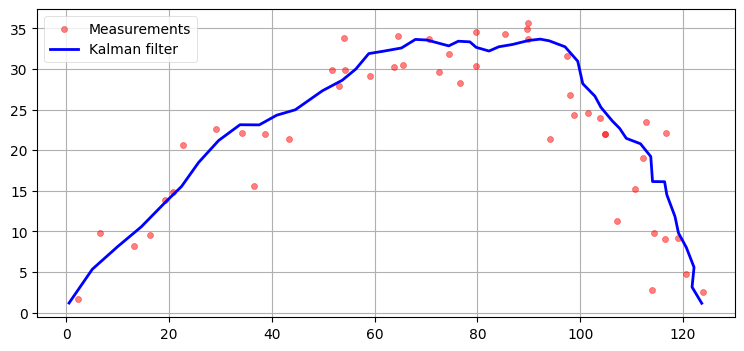

In [70]:
plot_ball_with_q(0.01, r=3, noise=3.)
plot_ball_with_q(0.1, r=3, noise=3.)

这个输出太可怕了。滤波器别无选择，只能比过程（预测步骤）赋予测量更多的权重，但是当测量有噪声时，滤波器输出只会跟踪噪声。线性卡尔曼滤波器的这种固有限制导致了滤波器非线性版本的发展。

话虽如此，当然可以使用过程噪声来处理系统中的小非线性。这是卡尔曼滤波器“魔法”的一部分。我们的传感器和系统模型从来都不是完美的。传感器是非高斯的，我们的过程模型从来都不是完美的。您可以通过将测量误差和过程误差设置为高于其理论正确值来掩盖其中的一部分，但折衷是一种非最佳解决方案。当然，非最优比让卡尔曼滤波器发散要好。然而，正如我们在上图中看到的那样，滤波器的输出很容易变得非常糟糕。运行许多模拟和测试并最终得到在这些条件下表现非常好的过滤器也是很常见的。然后，当您对真实数据使用过滤器时，条件会略有不同，过滤器最终会表现得非常糟糕。

现在我们将把这个问题放在一边，因为我们在这个例子中显然误用了卡尔曼滤波器。我们将在随后的章节中重新讨论这个问题，看看使用各种非线性技术的效果。在某些领域中，您可以使用线性卡尔曼滤波器来解决非线性问题，但通常您将不得不使用您将在本书其余部分中学习的一种或多种技术。

## References

[1] Bar-Shalom, Yaakov, et al. *Estimation with Applications to Tracking and Navigation.* John Wiley & Sons, 2001.